# NV Magnetometry State Estimation

In [13]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# --- Magnetometer System: Simulate reflection response based on current parameters ---
class NVMagnetometerSystem:
    def __init__(self, gamma_true=55e3, gs_true=0.019, noise_level=0.01):
        self.gamma_true = gamma_true  # homogeneous linewidth
        self.gs_true = gs_true        # coupling strength
        self.noise_level = noise_level # noise level in measurements
    
    def get_r2(self, frequency, spin_freq=2.87e9):
        # Simulate reflection coefficient based on gamma and gs 
        energy_d = 6.626e-34 * frequency   # h * omega
        kc0 = 130e3   # cavity linewidth
        kc1 = 130e3   # cavity loop coupling
#         k = 260e3
        k = 400e3
        gammao = 2.23e3  # optical polarization rate
        rho = 4  # NV density
        Vd = 3e-3*3e-3*0.9e-3  # diamond volume
        Gamma = 330e3 / 4 * rho   # inhomogeneous linewidth
        gamma_th = 90 # thermal relxation rate
        I = 1.225 * gammao - 4.809 * gamma_th + 3.085 * np.sqrt(0.1577 * gammao**2 - 0.5229 * gammao * gamma_th + gamma_th**2)
        Polarization = (0.29*I)/(3*gamma_th + 0.38*I)  #polarization factor based on excitation rate I
        N = (rho * 3.51 / 12.01 * 6.022e23) * Vd    # number of NVs
        g = np.sqrt(N*Polarization)*self.gs_true * 0.16   # collective coupling strength, factor of 0.16 to match 0.19MHz 
        Delta = spin_freq - frequency  # detuning of microwave drive from resonance
        alpha2 = 10**(-18 / 10) * 1e-3 / (energy_d * kc1 * 2 * np.pi) * (0.53**2)  # base case alpha^2
        beta2 = alpha2 * kc1  # base case beta^2
        chi_0 = np.sqrt(1 + 8 * (self.gamma_true / gammao) * (self.gs_true**2) * alpha2 / (self.gamma_true**2))
        Gamma_1_0 = Gamma + chi_0 * self.gamma_true
        geff_0 = g / chi_0
        term1 = kc1 * beta2
        term2 = (Delta - (g**2) * Delta / ((Gamma_1_0 / 2)**2 + Delta**2))**2
        term3 = (k / 2 + (geff_0**2) * (Gamma_1_0 / 2) / ((Gamma_1_0 / 2)**2 + Delta**2))**2
        alpha2_1 = term1 / (term2 + term3)  # compute alpha2 based on iterative procedure
        r2 = (-1 + np.sqrt(kc1*alpha2_1/beta2))**2 
        return r2 + np.random.normal(0, self.noise_level)  # Adding noise to the measured signal

# --- Agent: Bayesian update for parameters ---
class NVMagnetometerAgent:
    def __init__(self, gamma_prior_values, gs_prior_values, noise_level=0.01):
        self.gamma_prior_values = np.array(gamma_prior_values)
        self.gs_prior_values = np.array(gs_prior_values)
        self.noise_level = noise_level
        # Initialize uniform priors
        self.prior_gamma = np.ones(len(self.gamma_prior_values)) / len(self.gamma_prior_values)
        self.prior_gs = np.ones(len(self.gs_prior_values)) / len(self.gs_prior_values)

    def likelihood(self, measured_r2, frequency, gamma, gs):
        # Simulate reflection coefficient based on gamma and gs 
        energy_d = 6.626e-34 * frequency   # h * omega
        kc0 = 130e3   # cavity linewidth
        kc1 = 130e3   # cavity loop coupling
        k = 260e3
        gammao = 2.23e3  # optical polarization rate
        rho = 4
        Vd = 3e-3*3e-3*0.9e-3
        Gamma = 330e3 / 4 * rho
        gamma_th = 90 # thermal relxation rate
        I = 1.225 * gammao - 4.809 * gamma_th + 3.085 * np.sqrt(0.1577 * gammao**2 - 0.5229 * gammao * gamma_th + gamma_th**2)
        Polarization = (0.29*I)/(3*gamma_th + 0.38*I)
        N = (rho * 3.51 / 12.01 * 6.022e23) * Vd 
        g = np.sqrt(N*Polarization)*gs * 0.16
        Delta = 2.87e9 - frequency
        alpha2 = 10**(-18 / 10) * 1e-3 / (energy_d * kc1 * 2 * np.pi) * (0.53**2)  # base case alpha^2
        beta2 = alpha2 * kc1  # base case beta^2
        chi_0 = np.sqrt(1 + 8 * (gamma / gammao) * (gs**2) * alpha2 / (gamma**2))
        Gamma_1_0 = Gamma + chi_0 * gamma
        geff_0 = g / chi_0
        term1 = kc1 * beta2
        term2 = (Delta - (g**2) * Delta / ((Gamma_1_0 / 2)**2 + Delta**2))**2
        term3 = (k / 2 + (geff_0**2) * (Gamma_1_0 / 2) / ((Gamma_1_0 / 2)**2 + Delta**2))**2
        alpha2_1 = term1 / (term2 + term3)
        predicted_r2 = (-1 + np.sqrt(kc1*alpha2_1/beta2))**2
        if predicted_r2<0.01:
            noise = 1e-3
        else:
            noise = self.noise_level
        return norm.pdf(measured_r2, predicted_r2, noise)
    
    def update_posterior(self, measured_r2, frequency):
        posterior_gamma = np.zeros(len(self.gamma_prior_values))
        posterior_gs = np.zeros(len(self.gs_prior_values))
        for i, gamma in enumerate(self.gamma_prior_values):
            for j, gs in enumerate(self.gs_prior_values):
                likelihood_value = self.likelihood(measured_r2, frequency, gamma, gs)
                posterior_gamma[i] += likelihood_value * self.prior_gamma[i]
                posterior_gs[j] += likelihood_value * self.prior_gs[j]
        # Normalize the posterior distributions
        self.prior_gamma = posterior_gamma / np.sum(posterior_gamma)
        self.prior_gs = posterior_gs / np.sum(posterior_gs)
        return self.prior_gamma, self.prior_gs
    
    def calculate_entropy(self, prior_distribution):
        # Avoid log(0) by clipping very small values
        prior_distribution = np.clip(prior_distribution, 1e-10, None)
        return -np.sum(prior_distribution * np.log(prior_distribution))

    def print_entropies(self):
        entropy_gamma = self.calculate_entropy(self.prior_gamma)
        entropy_gs = self.calculate_entropy(self.prior_gs)
        print(f"Current Entropy for Gamma: {entropy_gamma:.4f}")
        print(f"Current Entropy for gs: {entropy_gs:.4f}")

    def expected_posterior_entropy(self, frequency, q_max_samples=10):
        # Simulate a range of possible measured responses
        simulated_r2 = np.logspace(-10, 0, q_max_samples)
        expected_entropy = 0
        
        for r2_sim in simulated_r2:
            posterior_gamma = np.zeros(len(self.gamma_prior_values))
            posterior_gs = np.zeros(len(self.gs_prior_values))
            
            for i, gamma in enumerate(self.gamma_prior_values):
                for j, gs in enumerate(self.gs_prior_values):
                    likelihood_value = self.likelihood(r2_sim, frequency, gamma, gs)
                    posterior_gamma[i] += likelihood_value * self.prior_gamma[i]
                    posterior_gs[j] += likelihood_value * self.prior_gs[j]
            
            # Normalize the posterior distributions
            posterior_gamma /= np.sum(posterior_gamma)
            posterior_gs /= np.sum(posterior_gs)
            
            # Calculate entropy of the posterior distributions
            entropy_gamma = self.calculate_entropy(posterior_gamma)
            entropy_gs = self.calculate_entropy(posterior_gs)
            
            # Average entropy for gamma and gs
            expected_entropy += (entropy_gamma + entropy_gs) / 2

        # Average over all simulated responses
        expected_entropy /= len(simulated_r2)
        return expected_entropy

    def calculate_information_gain(self, candidate_frequencies, q_max_samples=10):
        current_entropy_gamma = self.calculate_entropy(self.prior_gamma)
        current_entropy_gs = self.calculate_entropy(self.prior_gs)

        eigs = np.zeros(len(candidate_frequencies))
        for i, frequency in enumerate(candidate_frequencies):
            expected_entropy = self.expected_posterior_entropy(frequency, q_max_samples)
            eig_gamma = current_entropy_gamma - expected_entropy
            eig_gs = current_entropy_gs - expected_entropy
            eigs[i] = (eig_gamma + eig_gs) / 2  # Average expected information gain for gamma and gs

        return eigs
    
    def plot_priors(self, system):
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))

        # Plot posterior for gamma
        axs[0].bar(self.gamma_prior_values, self.prior_gamma, width=1e3, color='blue', label='Posterior Gamma')
        axs[0].axvline(x=system.gamma_true, color='red', linestyle='--', label='True Gamma')
        axs[0].set_xlabel("gamma (Hz)")
        axs[0].set_ylabel("Probability")
        axs[0].set_title(f"Prior Distribution for Gamma")
        axs[0].legend()

        # Plot posterior for gs
        axs[1].bar(self.gs_prior_values, self.prior_gs, width=1e-3, color='green', label='Posterior gs')
        axs[1].axvline(x=system.gs_true, color='red', linestyle='--', label='True gs')
        axs[1].set_xlabel("gs (Hz)")
        axs[1].set_ylabel("Probability")
        axs[1].set_title(f"Prior Distribution for gs")
        axs[1].legend()
        
        plt.tight_layout()
        plt.show()

    def plot_posteriors(self, step, candidate_frequencies, eigs, system):
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))

        # Plot posterior for gamma
        axs[0].bar(self.gamma_prior_values, self.prior_gamma, width=1e3, color='blue', label='Posterior Gamma')
        axs[0].axvline(x=system.gamma_true, color='red', linestyle='--', label='True Gamma')
        axs[0].set_xlabel("gamma (Hz)")
        axs[0].set_ylabel("Probability")
        axs[0].set_title(f"Posterior Distribution for Gamma (Step {step})")
        axs[0].legend()

        # Plot posterior for gs
        axs[1].bar(self.gs_prior_values, self.prior_gs, width=1e-3, color='green', label='Posterior gs')
        axs[1].axvline(x=system.gs_true, color='red', linestyle='--', label='True gs')
        axs[1].set_xlabel("gs (Hz)")
        axs[1].set_ylabel("Probability")
        axs[1].set_title(f"Posterior Distribution for gs (Step {step})")
        axs[1].legend()

        # Plot expected information gain
        axs[2].bar(candidate_frequencies, eigs, color='purple', width=1e3)
        axs[2].set_xlabel("Frequency (Hz)")
        axs[2].set_ylabel("Expected Information Gain")
        axs[2].set_title(f"Expected Information Gain (Step {step})")

        plt.tight_layout()
        plt.show()



### Frequency Selection by Expected Information Gain


Step 1:
Current Entropy for Gamma: 3.9120
Current Entropy for gs: 3.9120


/var/folders/tn/2cg70rks1hd5n1ghwrd7hd1w0000gn/T/ipykernel_17266/1549088058.py:122: RuntimeWarning: invalid value encountered in divide
  posterior_gamma /= np.sum(posterior_gamma)
/var/folders/tn/2cg70rks1hd5n1ghwrd7hd1w0000gn/T/ipykernel_17266/1549088058.py:123: RuntimeWarning: invalid value encountered in divide
  posterior_gs /= np.sum(posterior_gs)


Measured r2: 0.6914


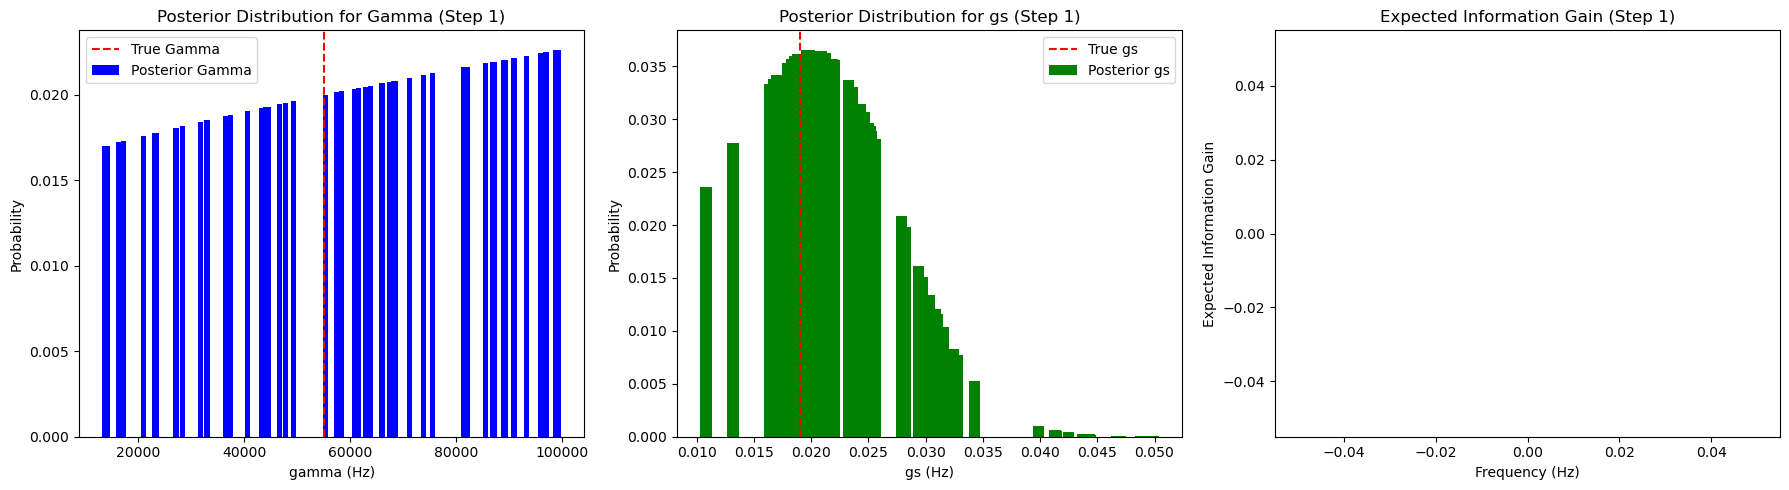


Step 2:
Current Entropy for Gamma: 3.9081
Current Entropy for gs: 3.5483
Measured r2: 0.7037


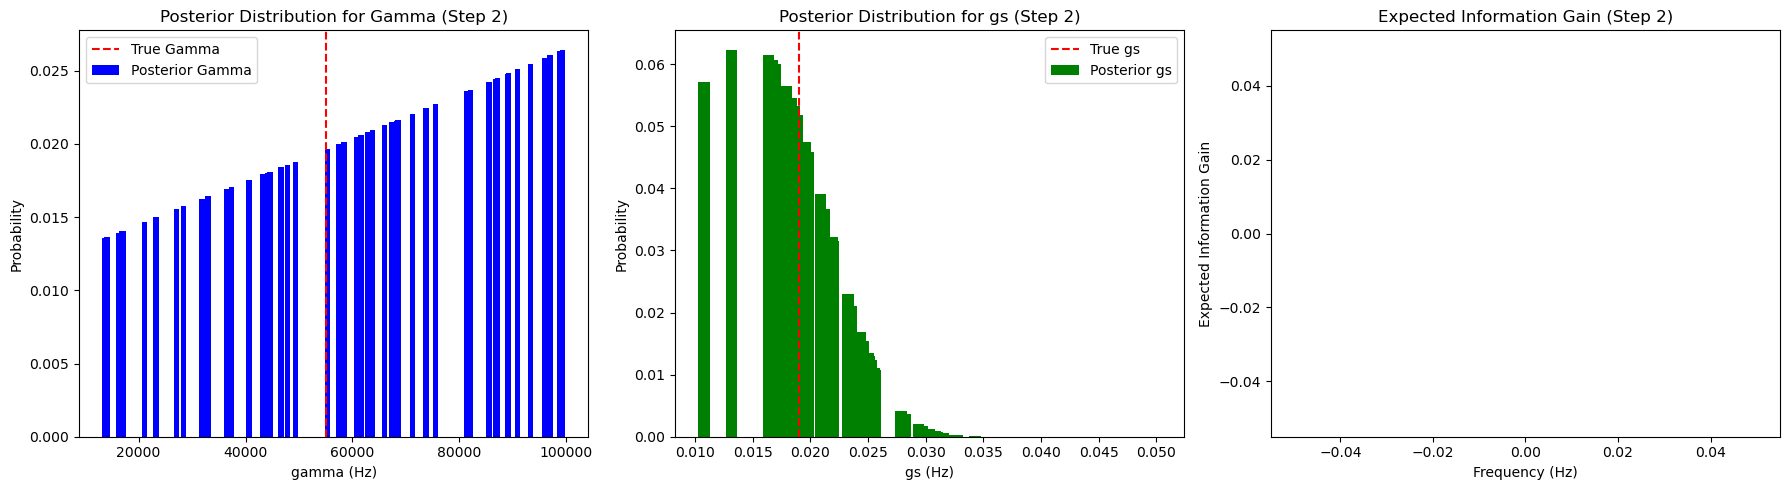


Step 3:
Current Entropy for Gamma: 3.8911
Current Entropy for gs: 3.1867
Measured r2: 0.6799


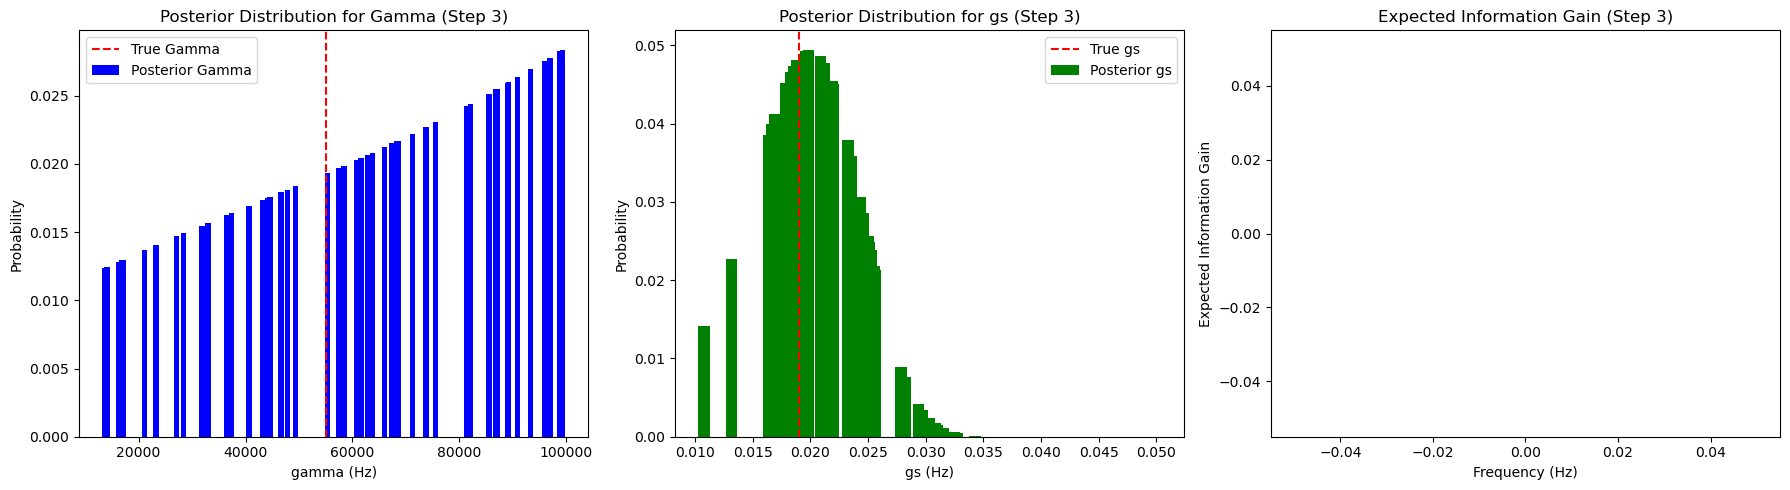


Step 4:
Current Entropy for Gamma: 3.8808
Current Entropy for gs: 3.3149
Measured r2: 0.6924


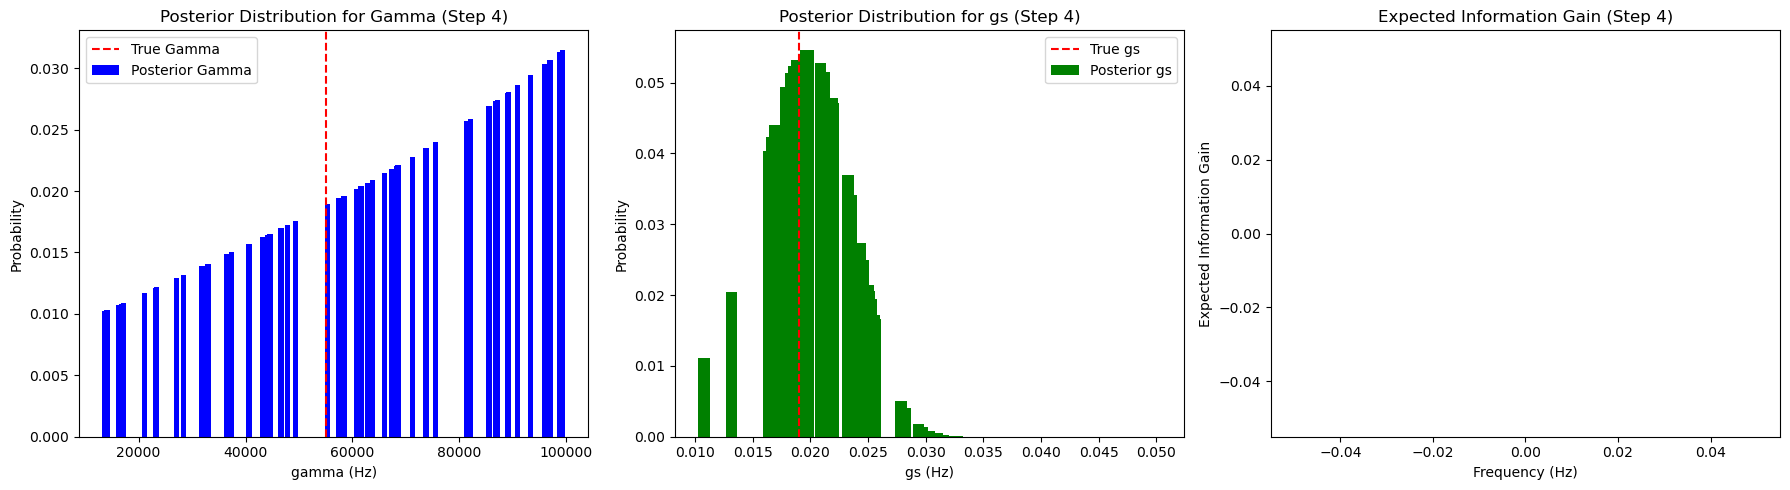


Step 5:
Current Entropy for Gamma: 3.8559
Current Entropy for gs: 3.2354
Measured r2: 0.7010


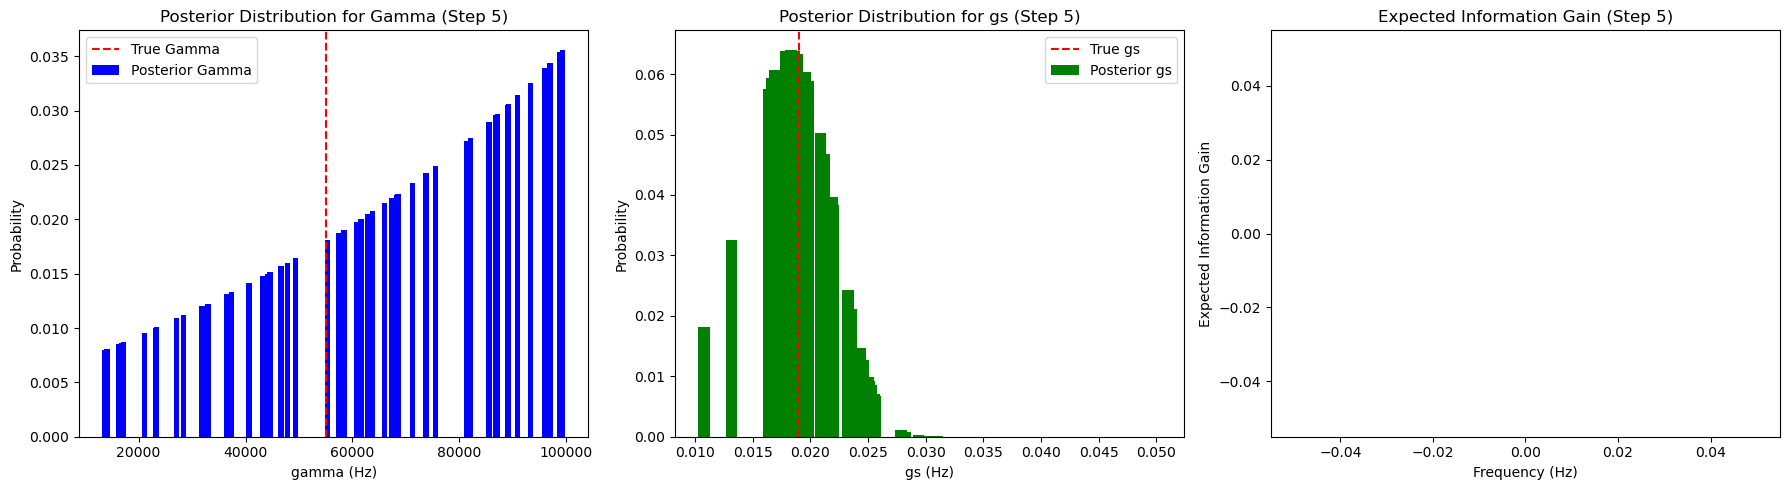


Step 6:
Current Entropy for Gamma: 3.8173
Current Entropy for gs: 3.0877
Measured r2: 0.7019


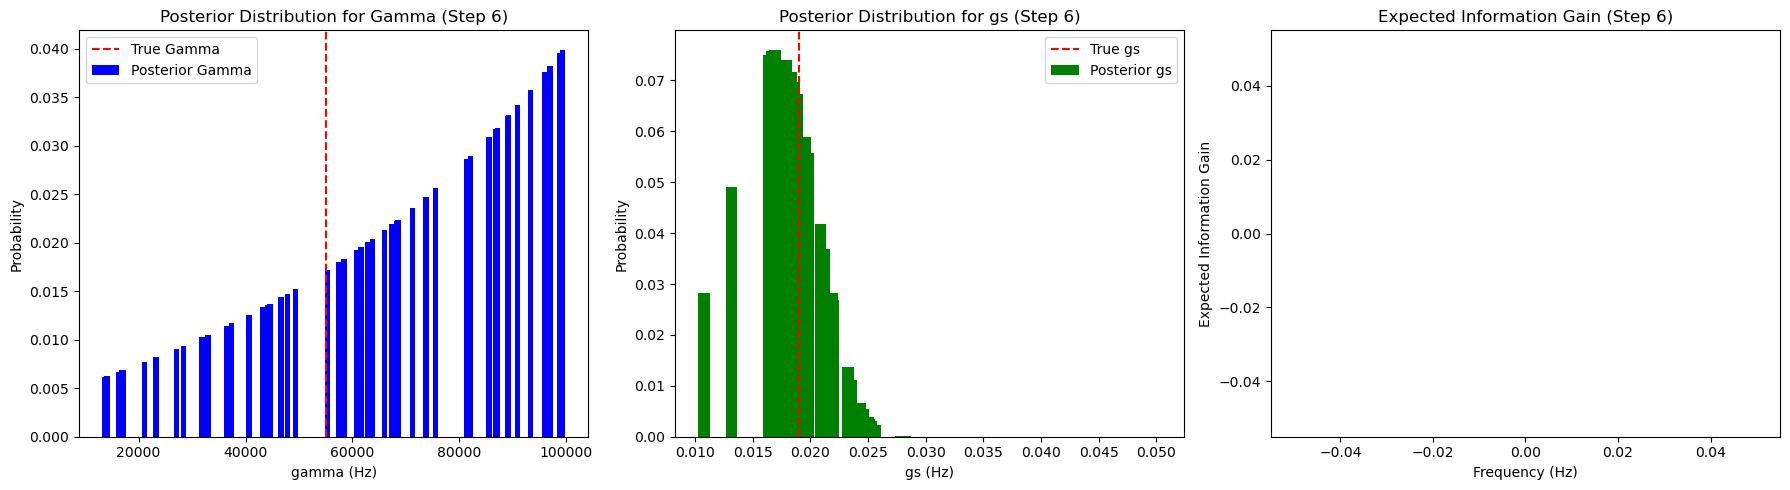


Step 7:
Current Entropy for Gamma: 3.7710
Current Entropy for gs: 2.9408
Measured r2: 0.7011


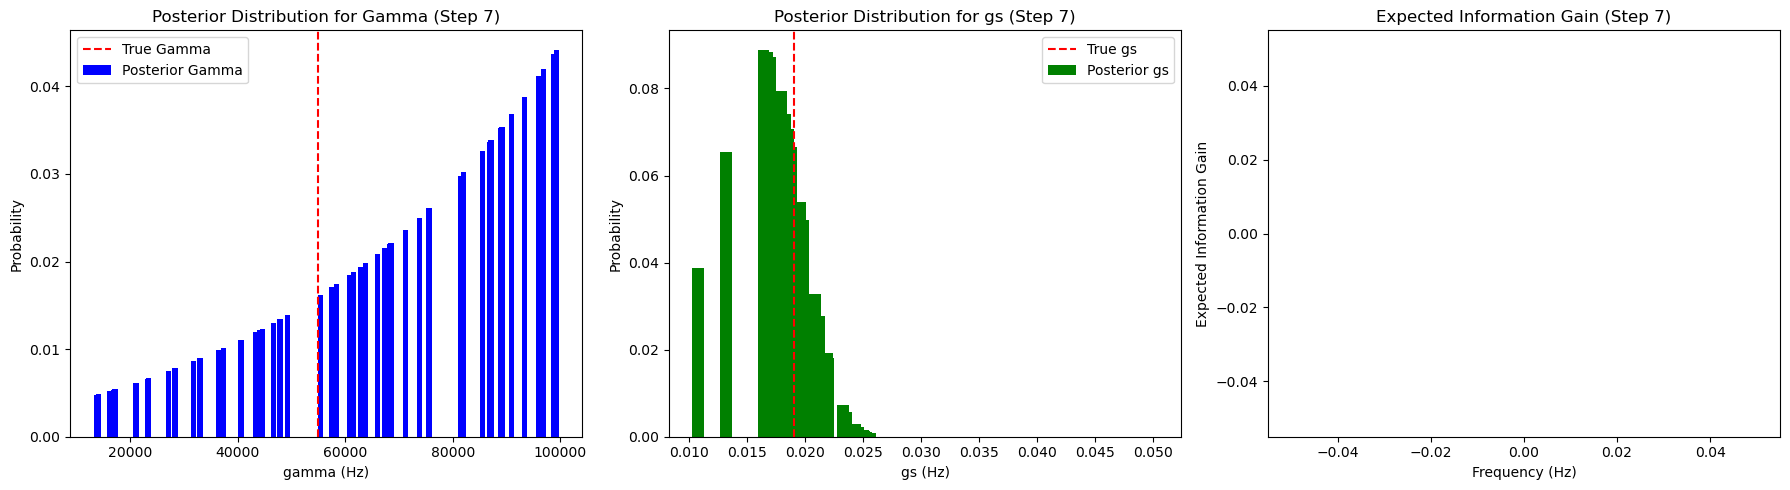


Step 8:
Current Entropy for Gamma: 3.7200
Current Entropy for gs: 2.8209
Measured r2: 0.6924


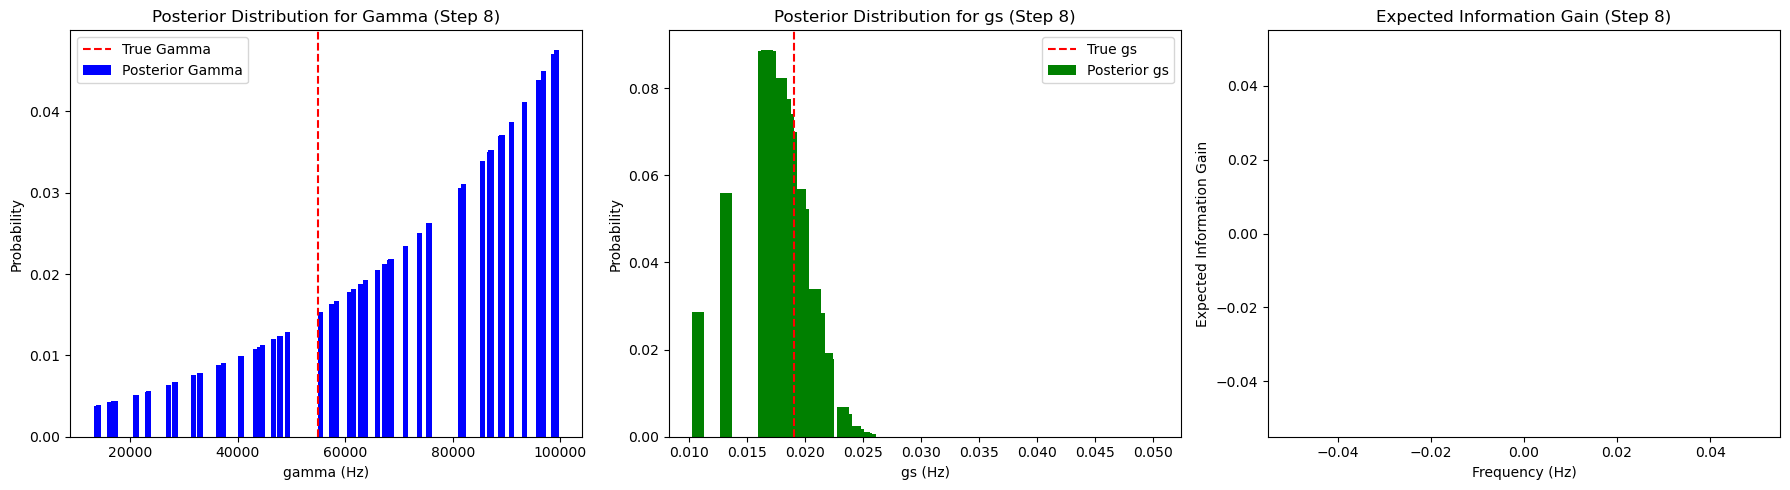


Step 9:
Current Entropy for Gamma: 3.6768
Current Entropy for gs: 2.8034
Measured r2: 0.6745


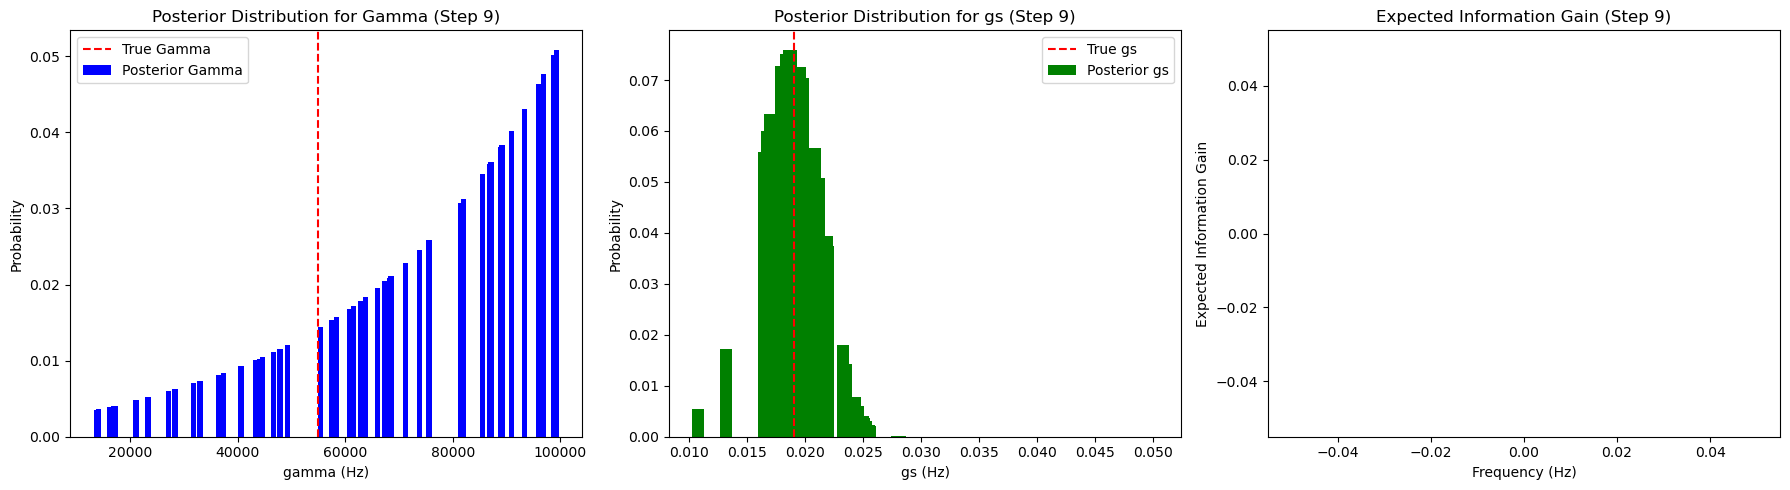


Step 10:
Current Entropy for Gamma: 3.6468
Current Entropy for gs: 2.9301
Measured r2: 0.6949


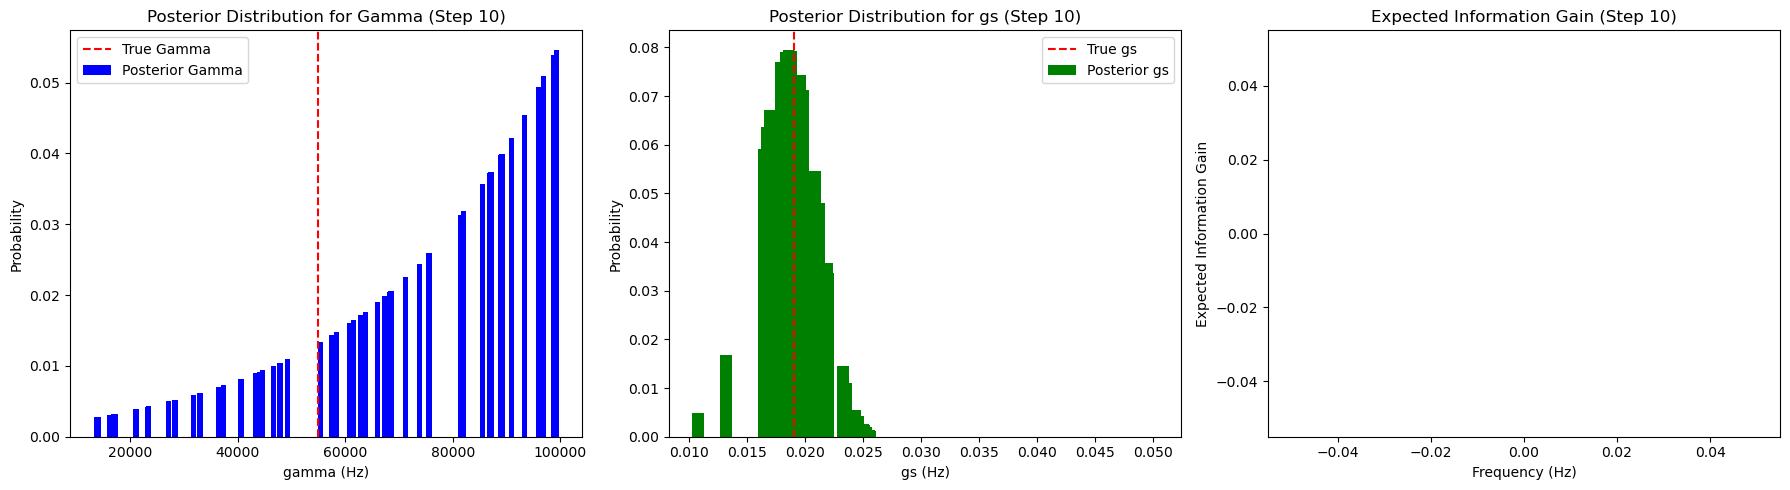

In [114]:

# Initialize gamma and gs prior ranges
gamma_prior_values = np.random.uniform(10e3, 100e3, 50)  # Prior range for gamma
gs_prior_values = np.random.uniform(0.01, 0.05, 50)   # Prior range for gs

# System initialization (true parameters)
system = NVMagnetometerSystem(gamma_true=55e3, gs_true=0.019)

# Agent initialization
agent_eig = NVMagnetometerAgent(gamma_prior_values, gs_prior_values)

# Sweep frequencies and update posterior
frequencies = 2.87e9 + np.linspace(-0.8, 0.8, 50)*1e6

num_steps = 10  # Number of steps for the experiment
for step in range(1, num_steps + 1):
    
    print(f"\nStep {step}:")

    # Before choosing the next frequency, print the current entropy
    agent_eig.print_entropies()

    # Calculate the expected information gain (EIG) for each candidate frequency
    eigs = agent_eig.calculate_information_gain(frequencies, q_max_samples=10)
#     print(f"Expected Information Gain for frequencies {frequencies}: {eigs}")

    # Select the next frequency with the highest EIG
    next_frequency = frequencies[np.argmax(eigs)]
#     print(f"Next frequency to measure: {next_frequency} Hz")

    # Challenger provides a response at the selected frequency
    r2_measured = system.get_r2(next_frequency)
    print(f"Measured r2: {r2_measured:.4f}")

    # Agent updates the posterior based on the measurement
    updated_prior_gamma, updated_prior_gs = agent_eig.update_posterior(r2_measured, next_frequency)
#     print(f"Updated posterior for gamma: {updated_prior_gamma}")
#     print(f"Updated posterior for gs: {updated_prior_gs}")

    # Plot the current state of posteriors and information gain
    agent_eig.plot_posteriors(step, frequencies, eigs, system)

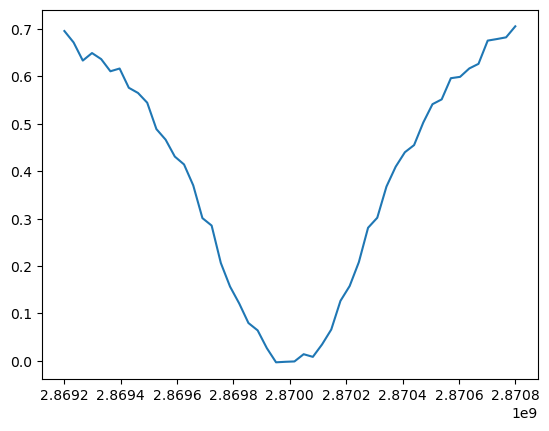

In [2]:
frequencies = 2.87e9 + np.linspace(-0.8, 0.8, 50)*1e6
r2s = []
new_system = NVMagnetometerSystem()
for i in range(len(frequencies)):
    r2s.append(new_system.get_r2(frequencies[i]))
plt.plot(frequencies, r2s)
plt.show()

### Frequency Sweep


Step 1:


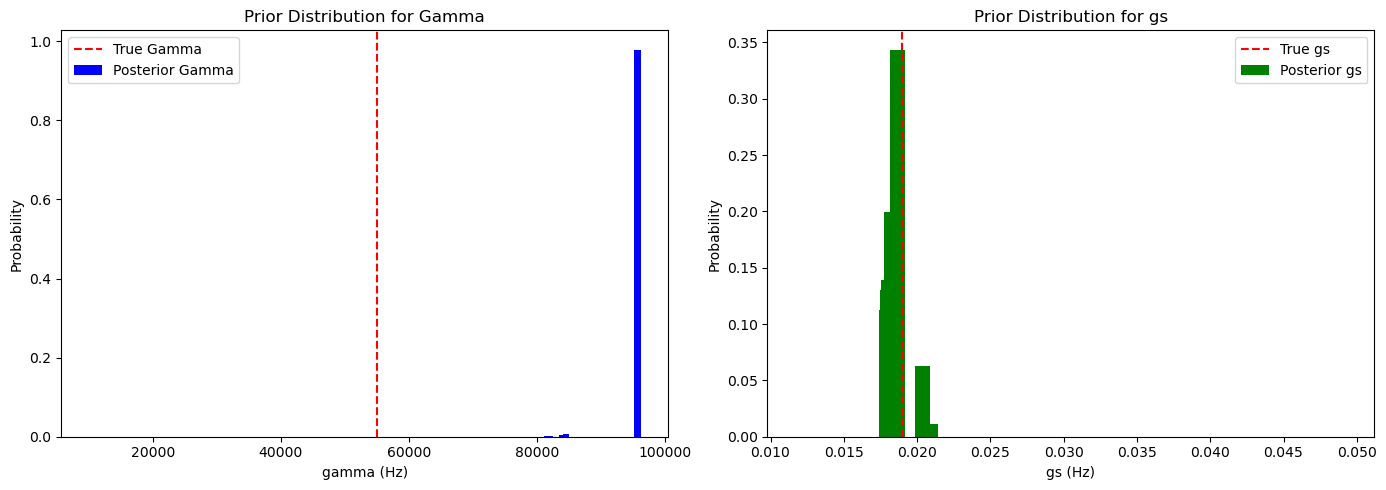


Step 2:


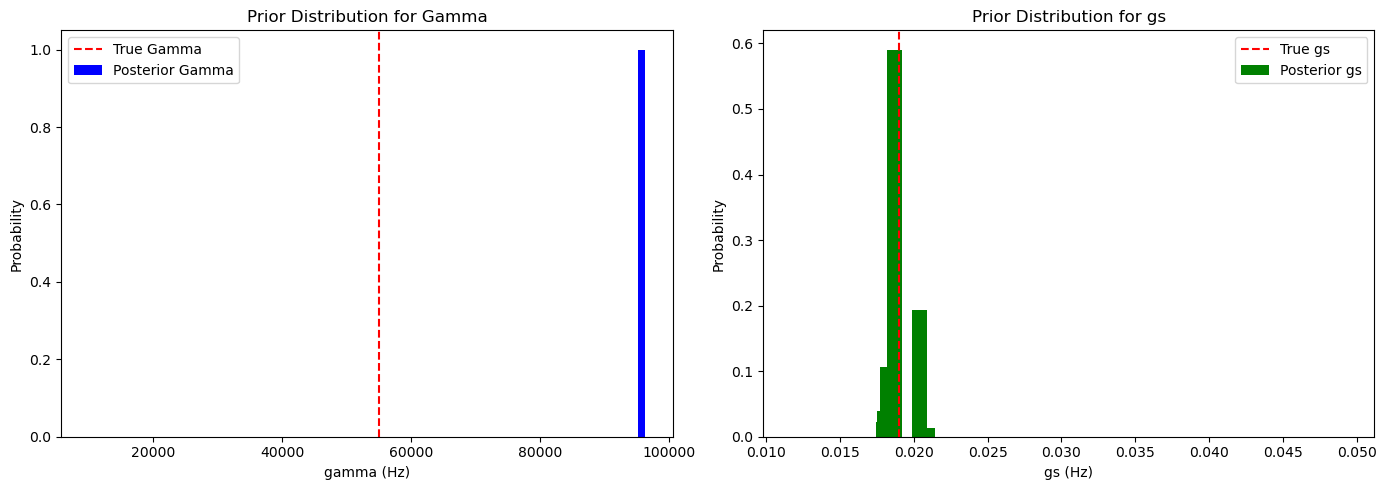


Step 3:


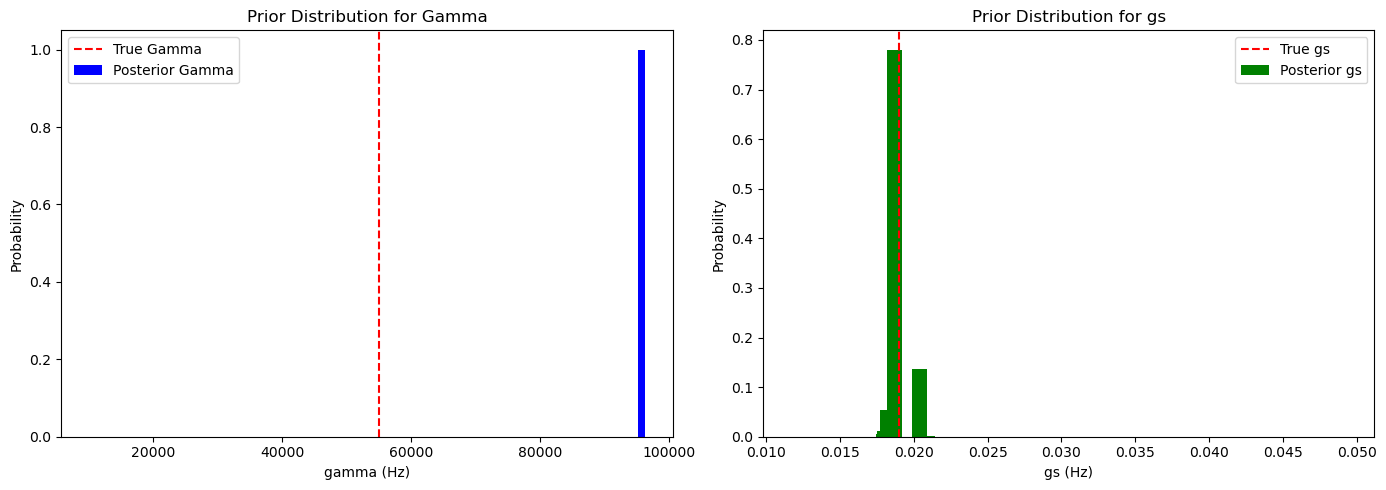


Step 4:


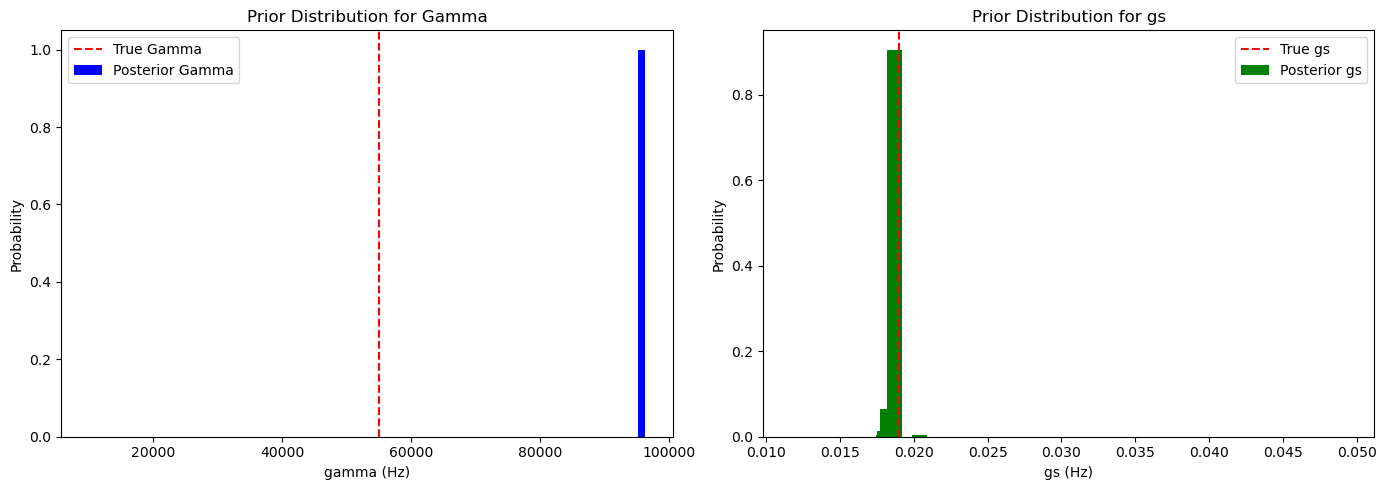

In [104]:
# Initialize gamma and gs prior ranges
gamma_prior_values = np.random.uniform(10e3, 100e3, 50)  # Prior range for gamma
gs_prior_values = np.random.uniform(0.01, 0.05, 50)   # Prior range for gs

# System initialization (true parameters)
system = NVMagnetometerSystem(gamma_true=55e3, gs_true=0.019)

# Agent initialization
agent_fs = NVMagnetometerAgent(gamma_prior_values, gs_prior_values)

# Define the frequency range for 20 frequencies
frequencies = 2.87e9 + np.linspace(-0.8, 0.8, 50)*1e6  # 20 frequencies

# Nested loop: 4 steps, each with 20 frequencies
num_steps = 4
for step in range(1, num_steps + 1):
    print(f"\nStep {step}:")
    
    for freq in frequencies:
        # Measure r2 at this frequency
        r2_measured = system.get_r2(freq)
        
        # Update the posterior based on the measurement
        updated_prior_gamma, updated_prior_gs = agent_fs.update_posterior(r2_measured, freq)

        # Optional: Print entropies after each update
#         agent.print_entropies()

    # Optional: Plot posteriors and entropies after each step
    agent_fs.plot_priors(system)  # No EIG needed in this case


### Gradient Based Frequency Selection


Step 1:
Measured r2 at frequency 2870747321.1788 Hz: 0.6566
Next frequency: 2870432198.3620 Hz


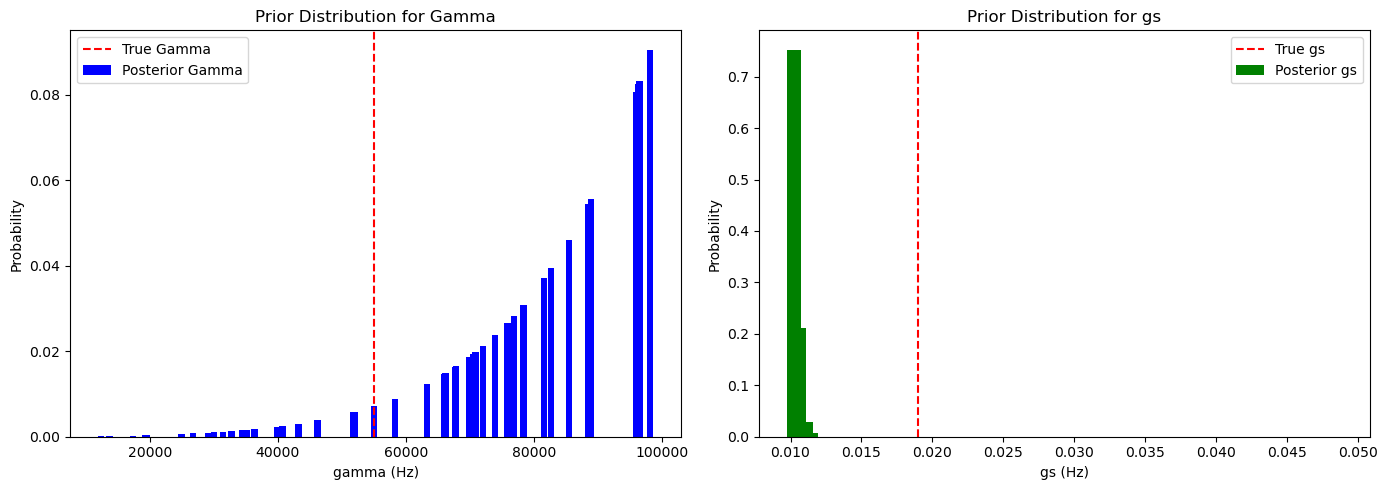


Step 2:
Measured r2 at frequency 2870432198.3620 Hz: 0.4664
Next frequency: 2870285501.3452 Hz


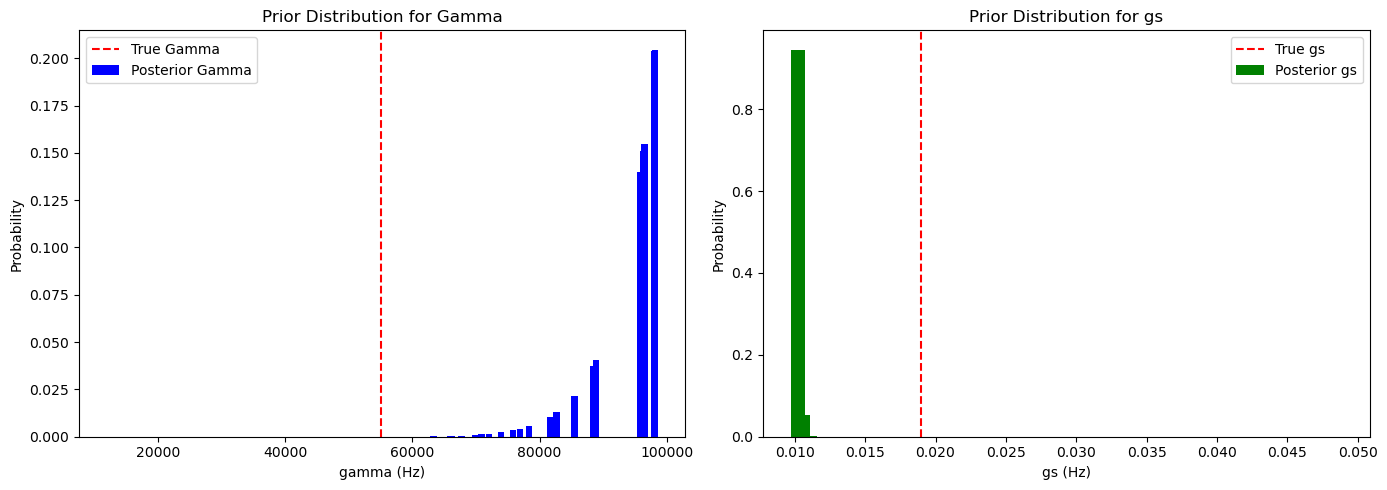


Step 3:
Measured r2 at frequency 2870285501.3452 Hz: 0.2737
Next frequency: 2869991572.1875 Hz


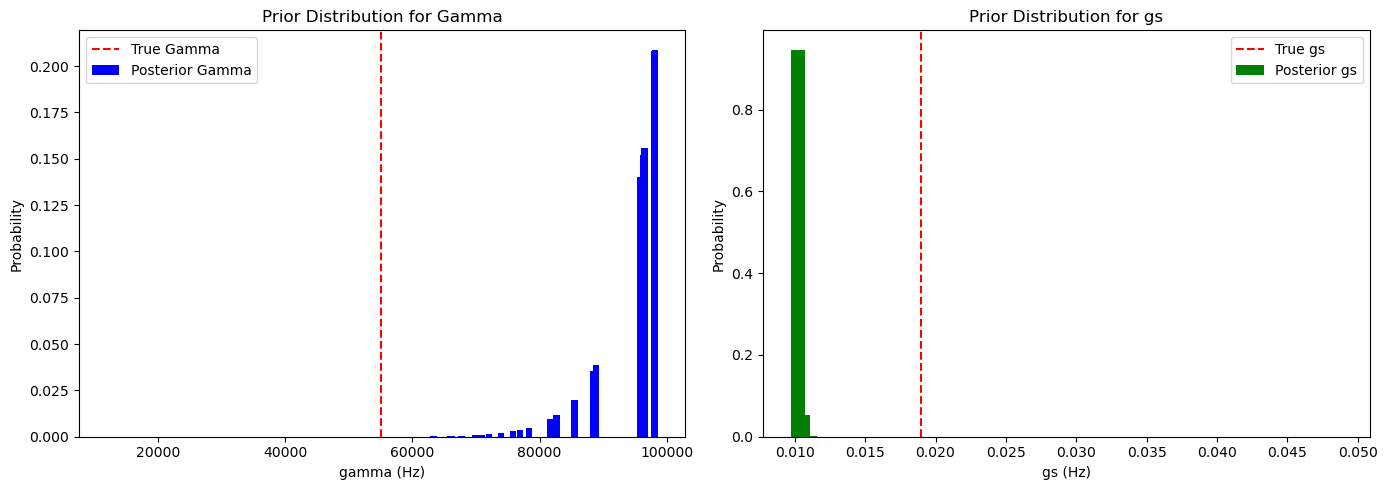


Step 4:
Measured r2 at frequency 2869991572.1875 Hz: -0.0023
Next frequency: 2870030391.6587 Hz


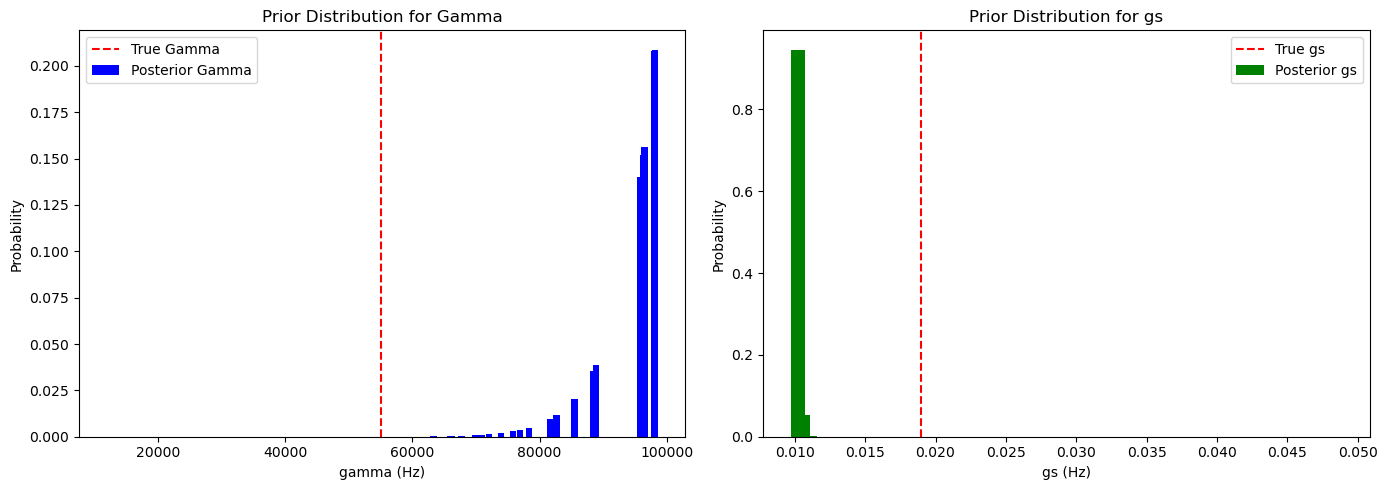


Step 5:
Measured r2 at frequency 2870030391.6587 Hz: 0.0031
Next frequency: 2869850148.9668 Hz


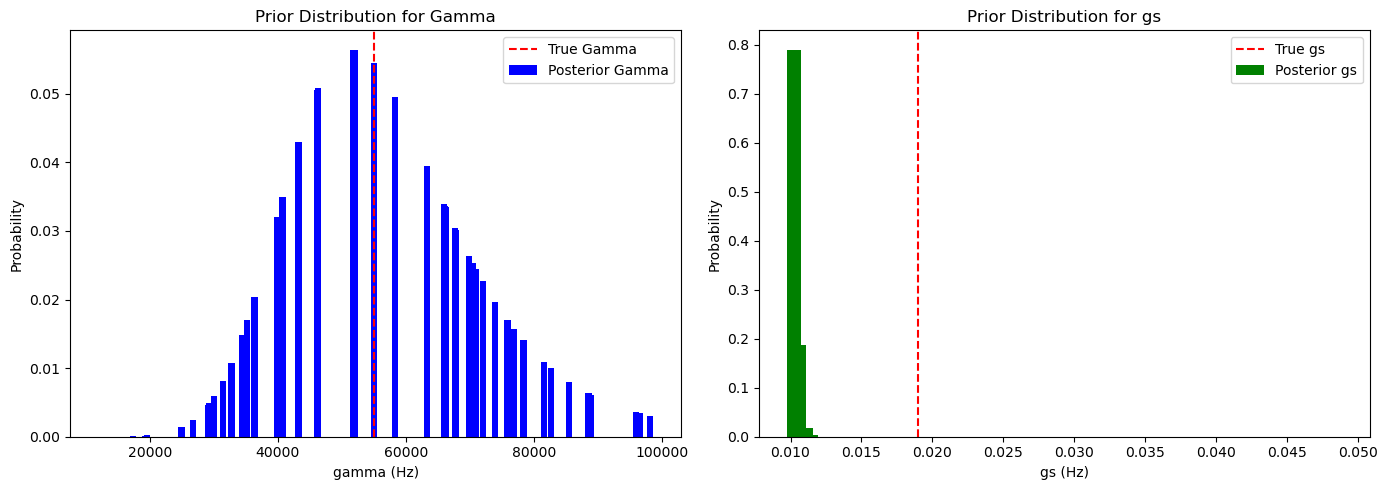


Step 6:
Measured r2 at frequency 2869850148.9668 Hz: 0.0526
Next frequency: 2869825322.4997 Hz


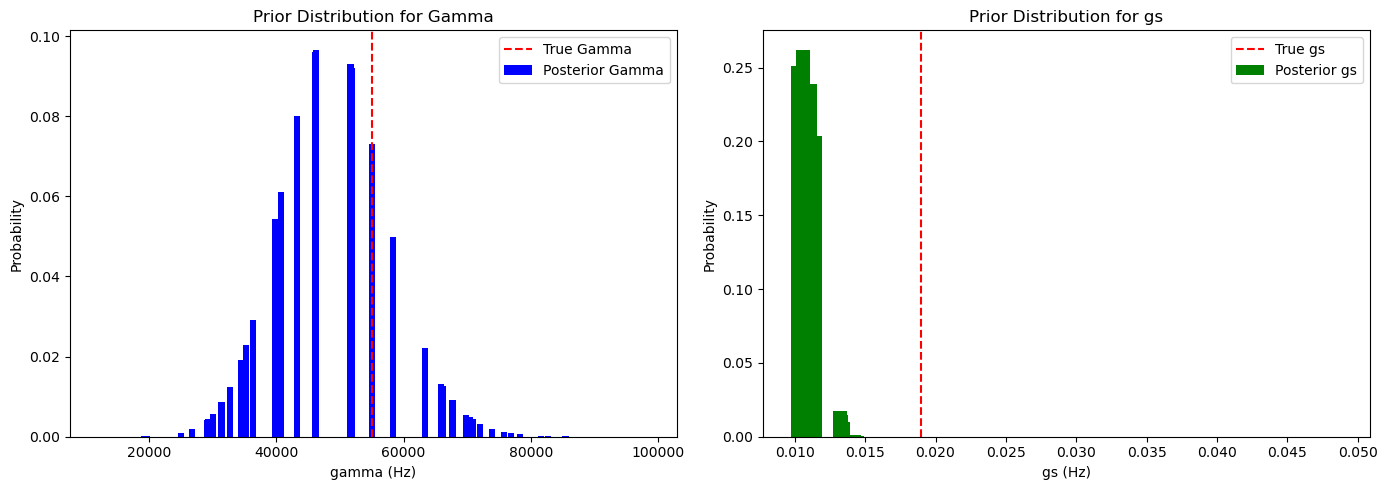


Step 7:
Measured r2 at frequency 2869825322.4997 Hz: 0.0918
Next frequency: 2869924371.9977 Hz


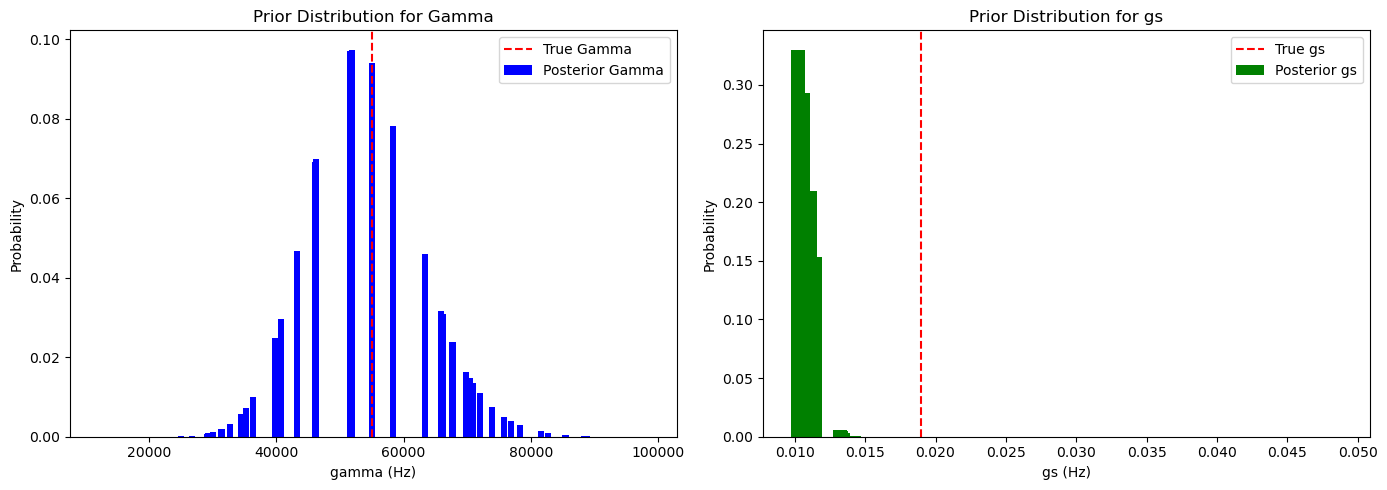


Step 8:
Measured r2 at frequency 2869924371.9977 Hz: 0.0064
Next frequency: 2869967491.5386 Hz


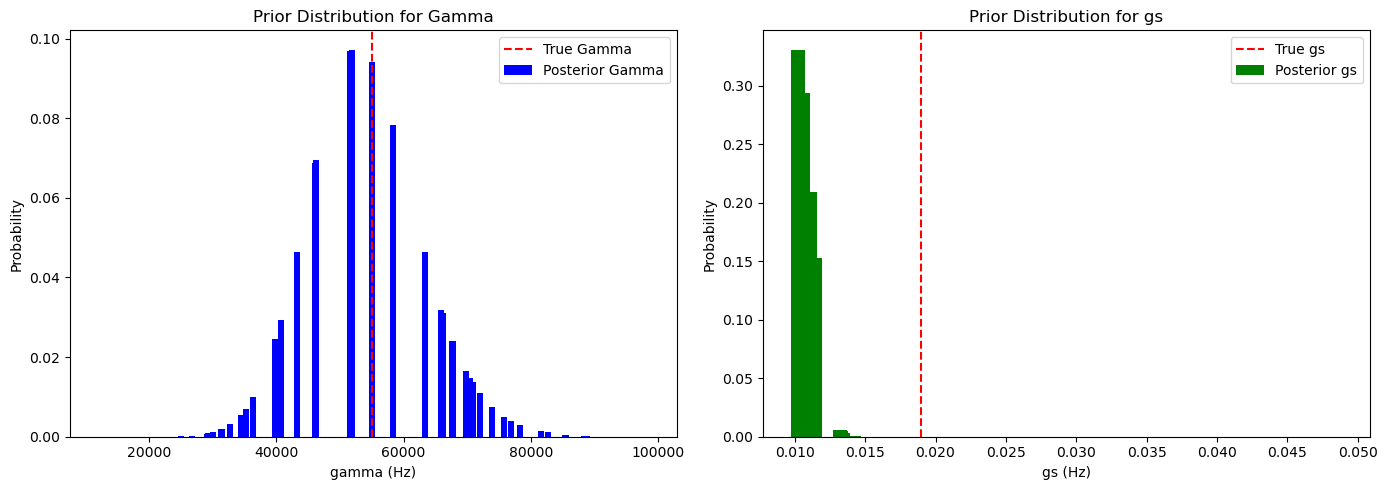


Step 9:
Measured r2 at frequency 2869967491.5386 Hz: -0.0203
Next frequency: 2869928738.1441 Hz


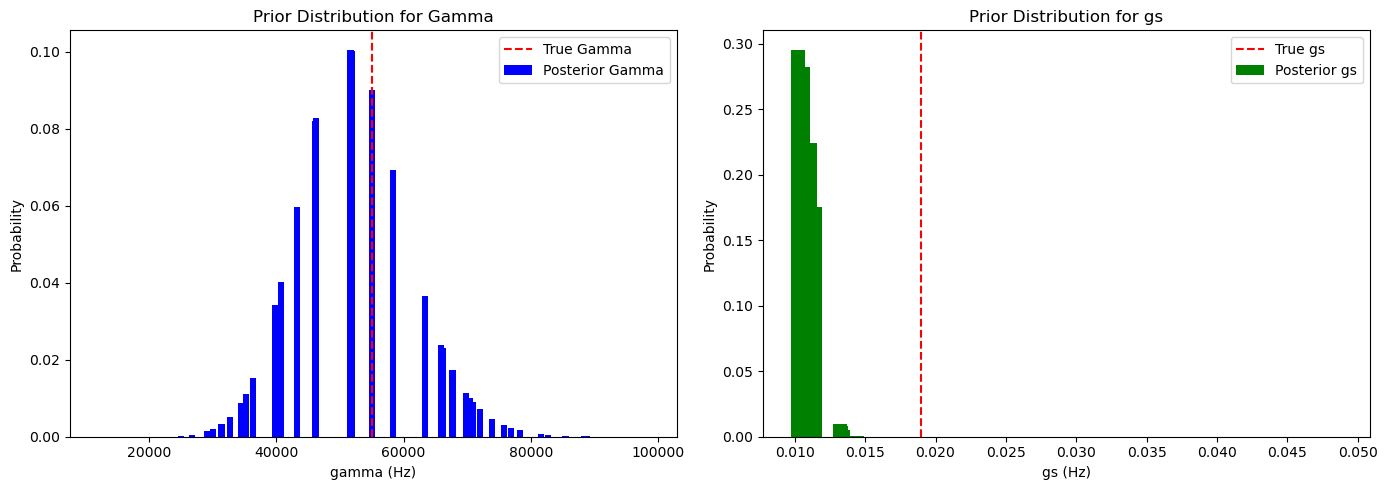


Step 10:
Measured r2 at frequency 2869928738.1441 Hz: 0.0247
Next frequency: 2870251440.6494 Hz


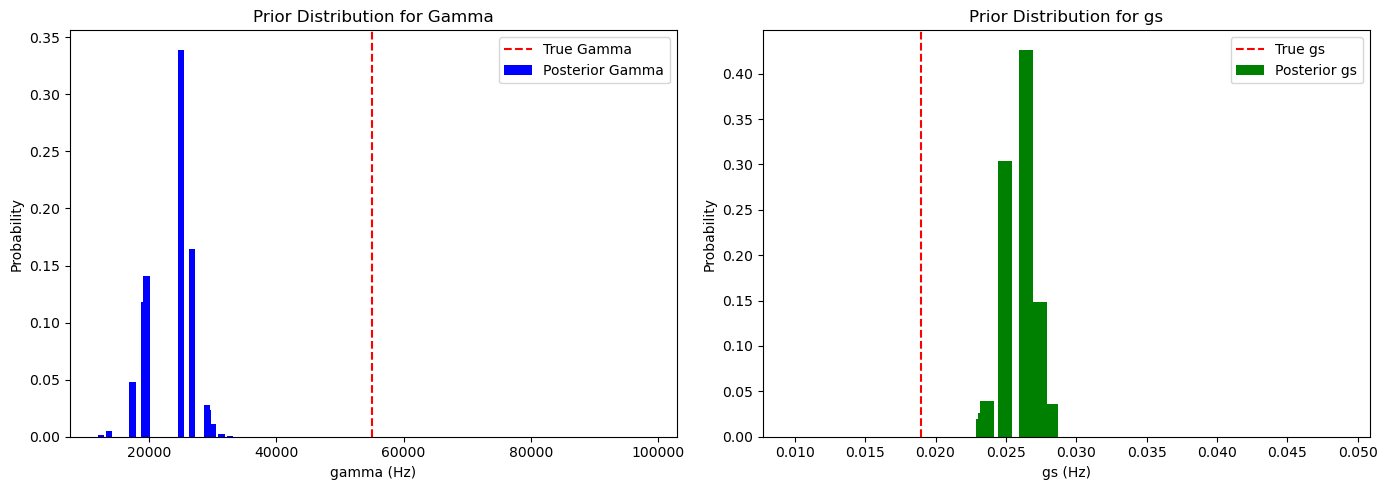

In [97]:
# Initialize gamma and gs prior ranges
gamma_prior_values = np.random.uniform(10e3, 100e3, 50)  # Prior range for gamma
gs_prior_values = np.random.uniform(0.01, 0.05, 50)   # Prior range for gs

# System initialization (true parameters)
system = NVMagnetometerSystem(gamma_true=55e3, gs_true=0.019)

# Agent initialization
agent_gd = NVMagnetometerAgent(gamma_prior_values, gs_prior_values)

# Define initial frequency (random start)
frequency = 2.87e9 + np.random.uniform(-0.8, 0.8)*1e6  # Random initial frequency

# Number of gradient steps
num_steps = 10
learning_rate = 1e11  # Small step toward minimizing r2

for step in range(1, num_steps + 1):
    print(f"\nStep {step}:")

    # Measure r2 at the current frequency
    r2_measured = system.get_r2(frequency)
    print(f"Measured r2 at frequency {frequency:.4f} Hz: {r2_measured:.4f}")

    # Compute gradient by measuring r2 at a slightly shifted frequency
    delta_freq = 1e4  # Small shift to estimate gradient
    r2_measured_shifted = system.get_r2(frequency + delta_freq)
    gradient = (r2_measured_shifted - r2_measured) / delta_freq
    
    # Update frequency: move in the direction of negative gradient (minimizing r2)
    frequency -= learning_rate * gradient
    print(f"Next frequency: {frequency:.4f} Hz")
    
    # Update the posterior based on the measurement
    updated_prior_gamma, updated_prior_gs = agent_gd.update_posterior(r2_measured, frequency)

    # Optional: Print entropies after each update
#     agent.print_entropies()

    # Optional: Plot posteriors and entropies after each step
    agent_gd.plot_priors(system)


### Binary Search


Step 1:
Measured r2 at frequency 2869295988.5980 Hz: 0.6430
Measured r2 at frequency 2869345988.5980 Hz: 0.6125
Measured r2 at frequency 2869395988.5980 Hz: 0.6062
Measured r2 at frequency 2869445988.5980 Hz: 0.5537
Measured r2 at frequency 2869495988.5980 Hz: 0.5249
Measured r2 at frequency 2869545988.5980 Hz: 0.4811
Measured r2 at frequency 2869595988.5980 Hz: 0.4311
Measured r2 at frequency 2869645988.5980 Hz: 0.3890
Measured r2 at frequency 2869695988.5980 Hz: 0.3207
Measured r2 at frequency 2869745988.5980 Hz: 0.2589
Measured r2 at frequency 2869845988.5980 Hz: 0.0626
Measured r2 at frequency 2869895988.5980 Hz: 0.0260
Measured r2 at frequency 2869945988.5980 Hz: 0.0017
Measured r2 at frequency 2869995988.5980 Hz: 0.0013
Measured r2 at frequency 2870045988.5980 Hz: 0.0003
Measured r2 at frequency 2870095988.5980 Hz: 0.0263
Measured r2 at frequency 2870145988.5980 Hz: 0.0586
Measured r2 at frequency 2870195988.5980 Hz: 0.1316
Measured r2 at frequency 2870245988.5980 Hz: 0.2198
Mea

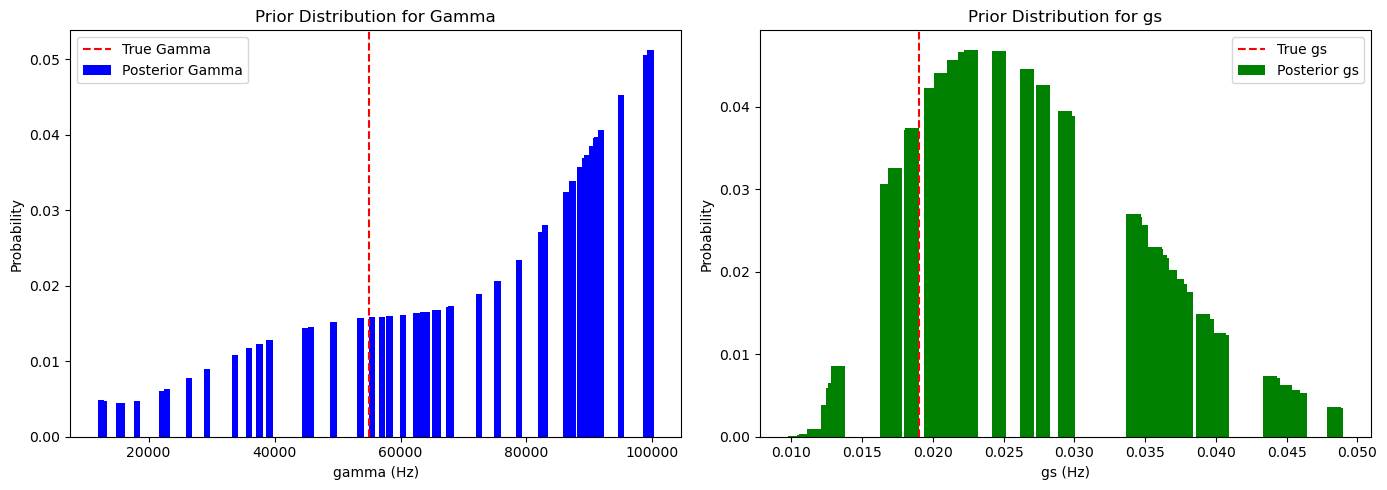


Step 2:
Measured r2 at frequency 2869820988.5980 Hz: 0.1361
Measured r2 at frequency 2869845988.5980 Hz: 0.0843
Measured r2 at frequency 2869870988.5980 Hz: 0.0418
Measured r2 at frequency 2869895988.5980 Hz: 0.0437
Measured r2 at frequency 2869920988.5980 Hz: 0.0252
Measured r2 at frequency 2869945988.5980 Hz: -0.0170
Measured r2 at frequency 2869970988.5980 Hz: 0.0030
Measured r2 at frequency 2869995988.5980 Hz: 0.0182
Measured r2 at frequency 2870020988.5980 Hz: 0.0046
Measured r2 at frequency 2870045988.5980 Hz: -0.0086
Measured r2 at frequency 2870095988.5980 Hz: 0.0043
Measured r2 at frequency 2870120988.5980 Hz: 0.0464
Measured r2 at frequency 2870145988.5980 Hz: 0.0704
Measured r2 at frequency 2870170988.5980 Hz: 0.1109
Measured r2 at frequency 2870195988.5980 Hz: 0.1419
Measured r2 at frequency 2870220988.5980 Hz: 0.1606
Measured r2 at frequency 2870245988.5980 Hz: 0.2152
Measured r2 at frequency 2870270988.5980 Hz: 0.2623
Measured r2 at frequency 2870295988.5980 Hz: 0.2907
M

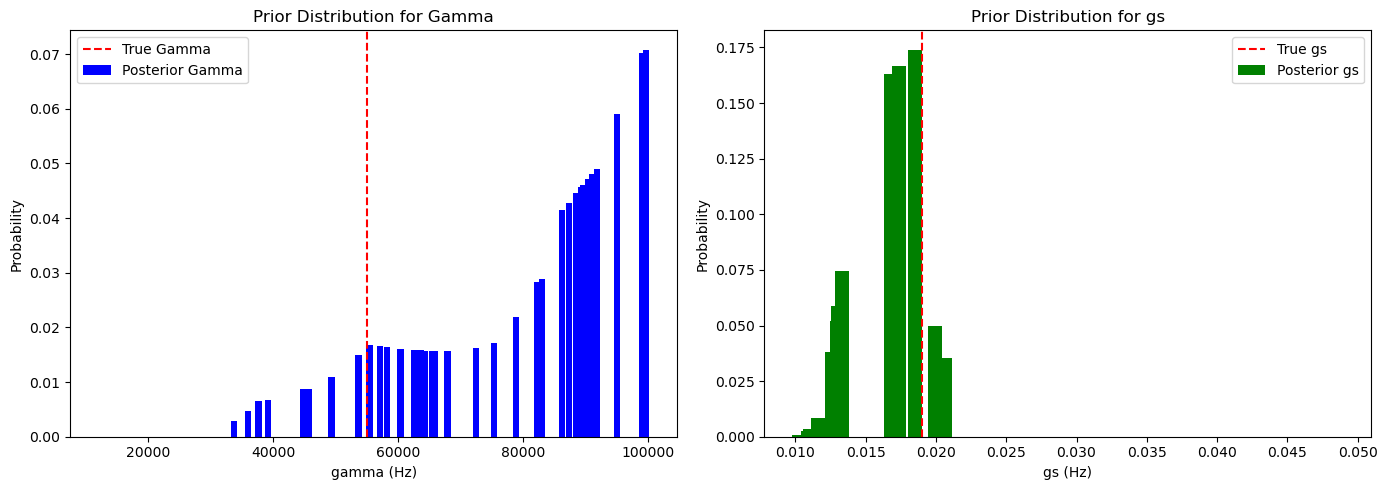


Step 3:
Measured r2 at frequency 2869808488.5980 Hz: 0.1427
Measured r2 at frequency 2869820988.5980 Hz: 0.1112
Measured r2 at frequency 2869833488.5980 Hz: 0.0890
Measured r2 at frequency 2869845988.5980 Hz: 0.0823
Measured r2 at frequency 2869858488.5980 Hz: 0.0838
Measured r2 at frequency 2869870988.5980 Hz: 0.0464
Measured r2 at frequency 2869883488.5980 Hz: 0.0373
Measured r2 at frequency 2869895988.5980 Hz: 0.0208
Measured r2 at frequency 2869908488.5980 Hz: 0.0184
Measured r2 at frequency 2869920988.5980 Hz: 0.0124
Measured r2 at frequency 2869945988.5980 Hz: -0.0036
Measured r2 at frequency 2869958488.5980 Hz: -0.0077
Measured r2 at frequency 2869970988.5980 Hz: -0.0071
Measured r2 at frequency 2869983488.5980 Hz: 0.0148
Measured r2 at frequency 2869995988.5980 Hz: 0.0046
Measured r2 at frequency 2870008488.5980 Hz: 0.0054
Measured r2 at frequency 2870020988.5980 Hz: -0.0048
Measured r2 at frequency 2870033488.5980 Hz: 0.0243
Measured r2 at frequency 2870045988.5980 Hz: 0.0015

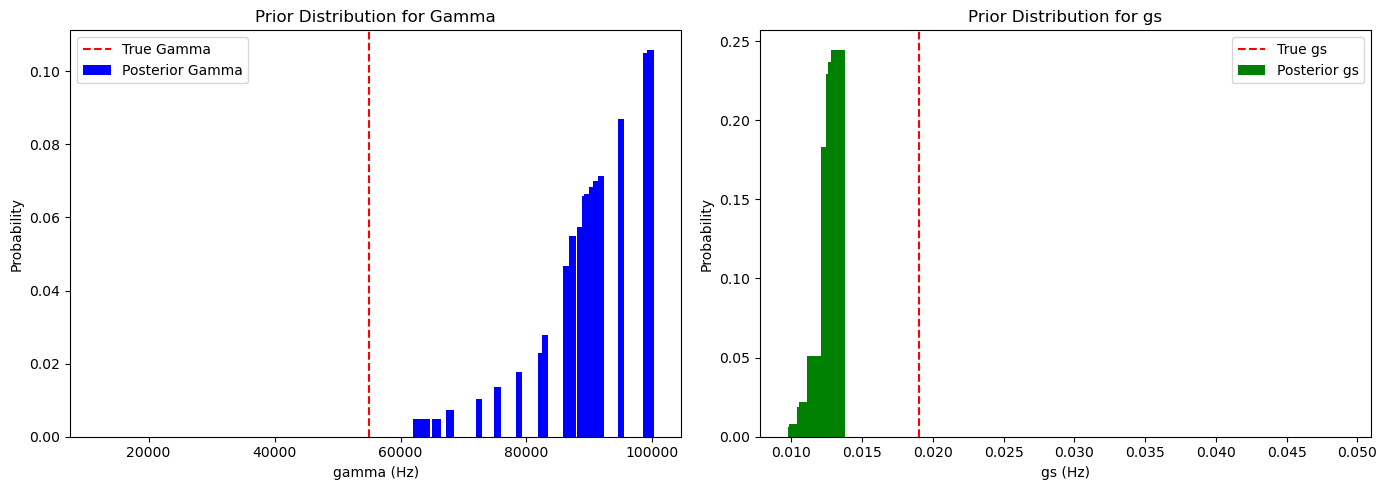


Step 4:
Measured r2 at frequency 2869939738.5980 Hz: 0.0173
Measured r2 at frequency 2869945988.5980 Hz: 0.0029
Measured r2 at frequency 2869952238.5980 Hz: 0.0029
Measured r2 at frequency 2869958488.5980 Hz: -0.0038
Measured r2 at frequency 2869964738.5980 Hz: 0.0100
Measured r2 at frequency 2869970988.5980 Hz: -0.0091
Measured r2 at frequency 2869977238.5980 Hz: 0.0132
Measured r2 at frequency 2869983488.5980 Hz: 0.0057
Measured r2 at frequency 2869989738.5980 Hz: -0.0137
Measured r2 at frequency 2869995988.5980 Hz: 0.0046
Measured r2 at frequency 2870008488.5980 Hz: -0.0123
Measured r2 at frequency 2870014738.5980 Hz: -0.0152
Measured r2 at frequency 2870020988.5980 Hz: 0.0033
Measured r2 at frequency 2870027238.5980 Hz: 0.0088
Measured r2 at frequency 2870033488.5980 Hz: -0.0149
Measured r2 at frequency 2870039738.5980 Hz: 0.0112
Measured r2 at frequency 2870045988.5980 Hz: 0.0176
Measured r2 at frequency 2870052238.5980 Hz: 0.0053
Measured r2 at frequency 2870058488.5980 Hz: -0.0

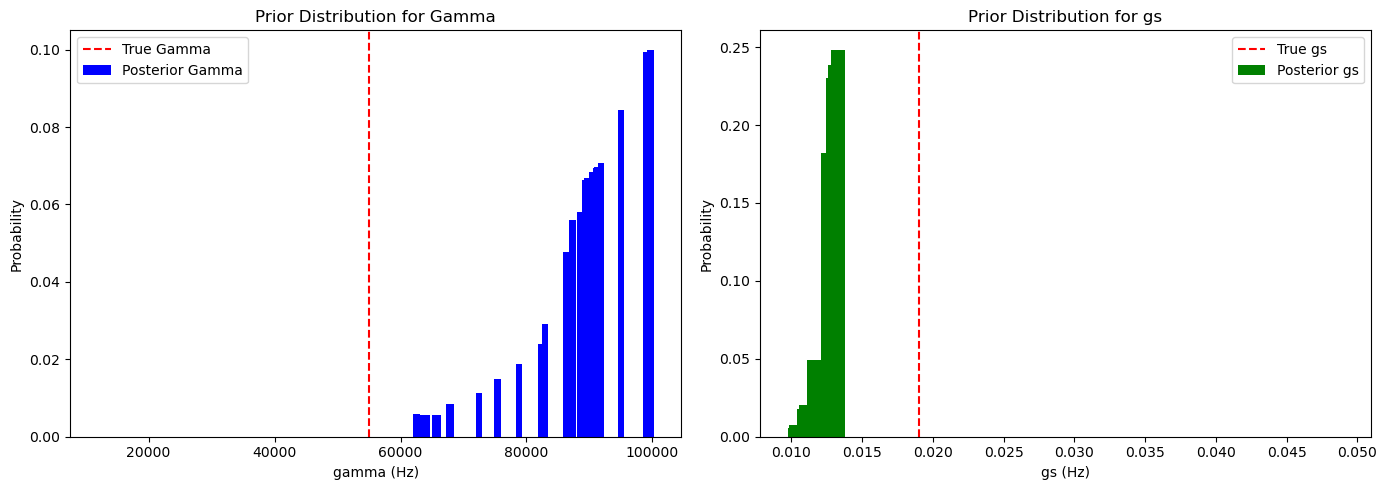


Step 5:
Measured r2 at frequency 2870005363.5980 Hz: -0.0025
Measured r2 at frequency 2870008488.5980 Hz: 0.0034
Measured r2 at frequency 2870011613.5980 Hz: 0.0038
Measured r2 at frequency 2870014738.5980 Hz: 0.0167
Measured r2 at frequency 2870017863.5980 Hz: -0.0109
Measured r2 at frequency 2870020988.5980 Hz: 0.0114
Measured r2 at frequency 2870024113.5980 Hz: 0.0123
Measured r2 at frequency 2870027238.5980 Hz: 0.0254
Measured r2 at frequency 2870030363.5980 Hz: 0.0016
Measured r2 at frequency 2870033488.5980 Hz: 0.0037
Measured r2 at frequency 2870039738.5980 Hz: -0.0072
Measured r2 at frequency 2870042863.5980 Hz: 0.0023
Measured r2 at frequency 2870045988.5980 Hz: -0.0002
Measured r2 at frequency 2870049113.5980 Hz: 0.0076
Measured r2 at frequency 2870052238.5980 Hz: 0.0087
Measured r2 at frequency 2870055363.5980 Hz: 0.0052
Measured r2 at frequency 2870058488.5980 Hz: -0.0245
Measured r2 at frequency 2870061613.5980 Hz: -0.0050
Measured r2 at frequency 2870064738.5980 Hz: 0.01

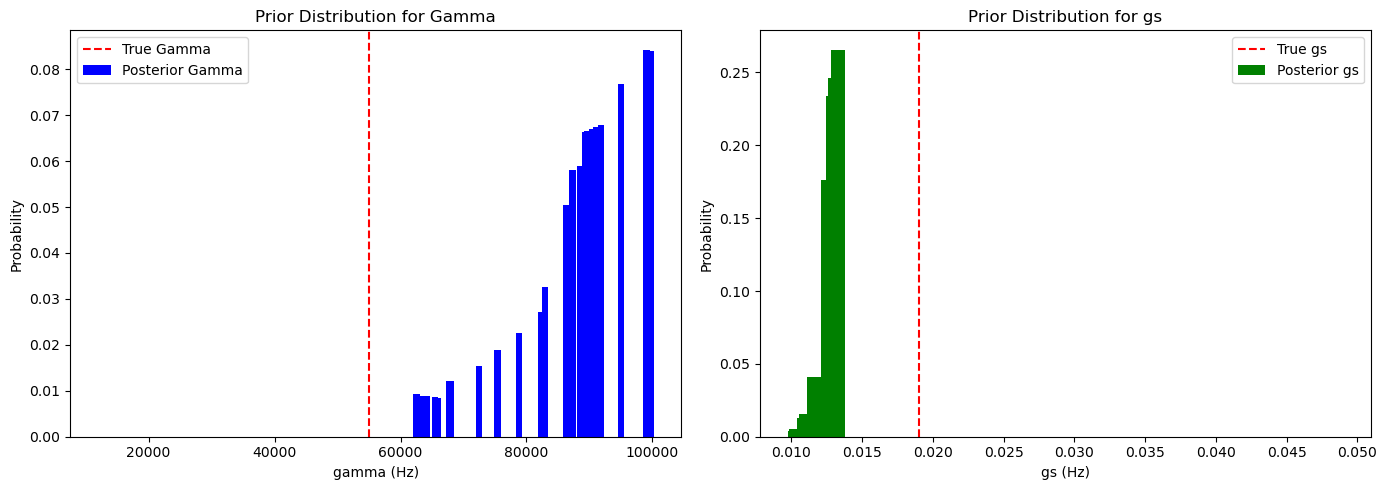


Step 6:
Measured r2 at frequency 2870038176.0980 Hz: 0.0065
Measured r2 at frequency 2870039738.5980 Hz: 0.0007
Measured r2 at frequency 2870041301.0980 Hz: -0.0059
Measured r2 at frequency 2870042863.5980 Hz: 0.0016
Measured r2 at frequency 2870044426.0980 Hz: 0.0121
Measured r2 at frequency 2870045988.5980 Hz: 0.0105
Measured r2 at frequency 2870047551.0980 Hz: 0.0069
Measured r2 at frequency 2870049113.5980 Hz: 0.0025
Measured r2 at frequency 2870050676.0980 Hz: -0.0063
Measured r2 at frequency 2870052238.5980 Hz: 0.0042
Measured r2 at frequency 2870055363.5980 Hz: 0.0076
Measured r2 at frequency 2870056926.0980 Hz: 0.0191
Measured r2 at frequency 2870058488.5980 Hz: 0.0087
Measured r2 at frequency 2870060051.0980 Hz: 0.0015
Measured r2 at frequency 2870061613.5980 Hz: 0.0080
Measured r2 at frequency 2870063176.0980 Hz: 0.0029
Measured r2 at frequency 2870064738.5980 Hz: 0.0226
Measured r2 at frequency 2870066301.0980 Hz: 0.0260
Measured r2 at frequency 2870067863.5980 Hz: 0.0086
M

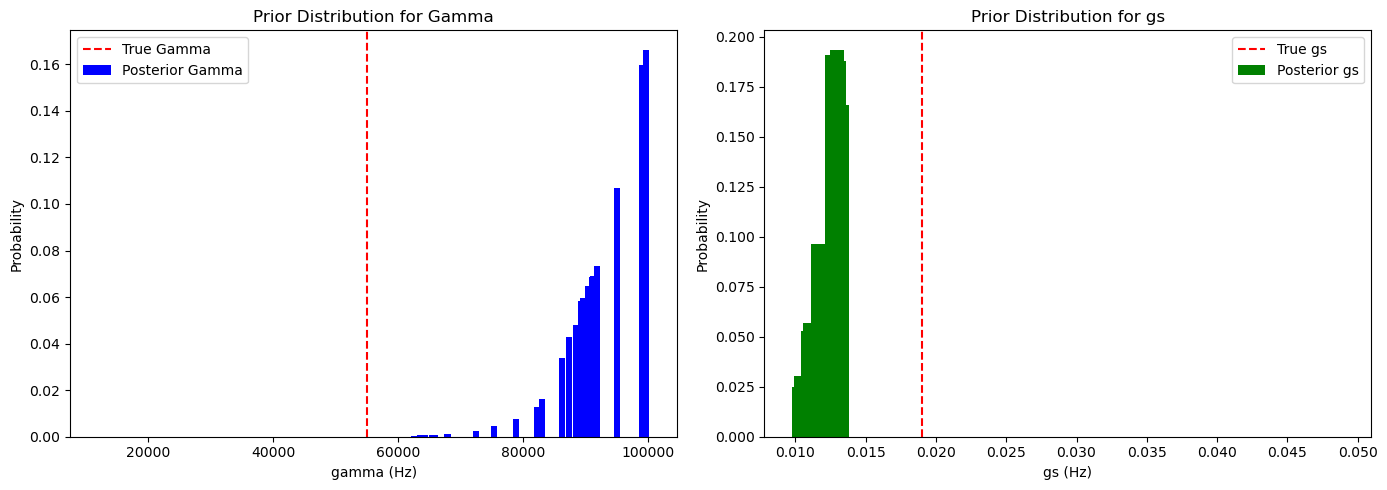


Step 7:
Measured r2 at frequency 2870037394.8480 Hz: -0.0131
Measured r2 at frequency 2870038176.0980 Hz: 0.0077
Measured r2 at frequency 2870038957.3480 Hz: -0.0089
Measured r2 at frequency 2870039738.5980 Hz: 0.0067
Measured r2 at frequency 2870040519.8480 Hz: 0.0045
Measured r2 at frequency 2870041301.0980 Hz: 0.0039
Measured r2 at frequency 2870042082.3480 Hz: -0.0070
Measured r2 at frequency 2870042863.5980 Hz: -0.0116
Measured r2 at frequency 2870043644.8480 Hz: 0.0176
Measured r2 at frequency 2870044426.0980 Hz: 0.0032
Measured r2 at frequency 2870045988.5980 Hz: 0.0091
Measured r2 at frequency 2870046769.8480 Hz: -0.0012
Measured r2 at frequency 2870047551.0980 Hz: -0.0031
Measured r2 at frequency 2870048332.3480 Hz: 0.0099
Measured r2 at frequency 2870049113.5980 Hz: 0.0080
Measured r2 at frequency 2870049894.8480 Hz: -0.0150
Measured r2 at frequency 2870050676.0980 Hz: -0.0034
Measured r2 at frequency 2870051457.3480 Hz: 0.0040
Measured r2 at frequency 2870052238.5980 Hz: 0.

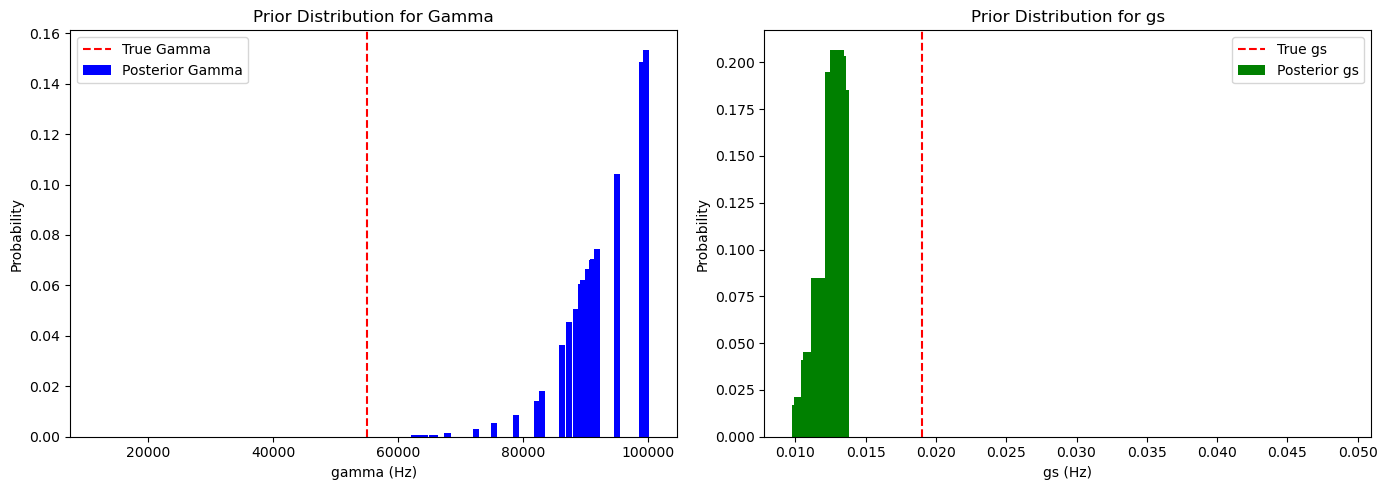


Step 8:
Measured r2 at frequency 2870037004.2230 Hz: -0.0037
Measured r2 at frequency 2870037394.8480 Hz: 0.0042
Measured r2 at frequency 2870037785.4730 Hz: 0.0094
Measured r2 at frequency 2870038176.0980 Hz: -0.0069
Measured r2 at frequency 2870038566.7230 Hz: -0.0144
Measured r2 at frequency 2870038957.3480 Hz: -0.0013
Measured r2 at frequency 2870039347.9730 Hz: -0.0160
Measured r2 at frequency 2870039738.5980 Hz: 0.0037
Measured r2 at frequency 2870040129.2230 Hz: 0.0050
Measured r2 at frequency 2870040519.8480 Hz: 0.0041
Measured r2 at frequency 2870041301.0980 Hz: 0.0013
Measured r2 at frequency 2870041691.7230 Hz: 0.0038
Measured r2 at frequency 2870042082.3480 Hz: -0.0109
Measured r2 at frequency 2870042472.9730 Hz: -0.0153
Measured r2 at frequency 2870042863.5980 Hz: -0.0069
Measured r2 at frequency 2870043254.2230 Hz: -0.0145
Measured r2 at frequency 2870043644.8480 Hz: 0.0085
Measured r2 at frequency 2870044035.4730 Hz: -0.0062
Measured r2 at frequency 2870044426.0980 Hz: 

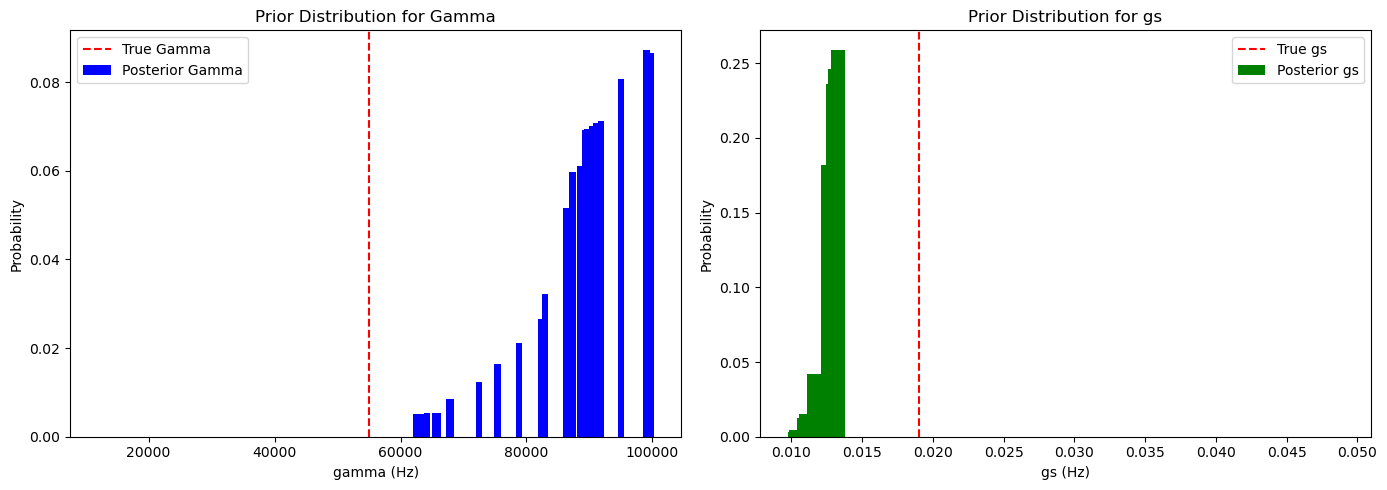

In [112]:
# Initialize gamma and gs prior ranges
gamma_prior_values = np.random.uniform(10e3, 100e3, 50)  # Prior range for gamma
gs_prior_values = np.random.uniform(0.01, 0.05, 50)   # Prior range for gs

# System initialization (true parameters)
system = NVMagnetometerSystem(gamma_true=55e3, gs_true=0.019)

# Agent initialization
agent_bs = NVMagnetometerAgent(gamma_prior_values, gs_prior_values)

# Define initial random frequency
initial_frequency = 2.87e9 + np.random.uniform(-0.8, 0.8)*1e6  # Random initial frequency

# Sparse sweep parameters
num_samples = 20  # Total number of sweep samples
half_samples = num_samples // 2
step_size = 0.1e6  # Frequency step size for the sweep

# Number of binary search steps
num_steps = 8

for step in range(1, num_steps + 1):
    print(f"\nStep {step}:")
    
    # Update the posterior based on the measurement at central frequency
    r2_measured = system.get_r2(initial_frequency)
    updated_prior_gamma, updated_prior_gs = agent_bs.update_posterior(r2_measured, initial_frequency)
    
    # Generate sweep frequencies around the current frequency
    left_sweep = initial_frequency - np.linspace(half_samples, 1, half_samples) * step_size/(2**step)
    right_sweep = initial_frequency + np.linspace(1, half_samples, half_samples) * step_size/(2**step)
    sweep_frequencies = np.concatenate([left_sweep, right_sweep])
    
    # Measure r2 at each sweep frequency and integrate
    left_r2_sum = 0
    right_r2_sum = 0
    for i, freq in enumerate(sweep_frequencies):
        r2_measured = system.get_r2(freq)
        print(f"Measured r2 at frequency {freq:.4f} Hz: {r2_measured:.4f}")
        
        # Sum r2 for left and right sweeps
        if i < half_samples:
            left_r2_sum += r2_measured
        else:
            right_r2_sum += r2_measured
    
    # Compare integrated r2 and decide next frequency
    if left_r2_sum < right_r2_sum:
        # Move to the middle of the left side (closer to resonance)
        initial_frequency = (left_sweep[0] + left_sweep[-1]) / 2
    else:
        # Move to the middle of the right side (closer to resonance)
        initial_frequency = (right_sweep[0] + right_sweep[-1]) / 2
    
    print(f"Next frequency to measure: {initial_frequency:.4f} Hz")

    # Optional: Plot posteriors and entropies after each step
    agent_bs.plot_priors(system)


## Learning Through a Neural Net

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Constants (defined as PyTorch tensors)
h = torch.tensor(6.626e-34, dtype=torch.float32)  # Planck constant (J·s)
mu_B = torch.tensor(9.274009994e-24, dtype=torch.float32)  # Bohr magneton (J/T)
g_e = torch.tensor(2.00231930436256, dtype=torch.float32)  # Electron g-factor

kc0 = torch.tensor(130e3, dtype=torch.float32)    # Cavity linewidth (Hz)
kc1 = torch.tensor(130e3, dtype=torch.float32)    # Cavity loop coupling (Hz)
k = torch.tensor(260e3, dtype=torch.float32)      # Total cavity decay rate (Hz)
gammao = torch.tensor(2.23e3, dtype=torch.float32)  # Optical polarization rate (Hz)
rho = torch.tensor(4.0, dtype=torch.float32)          # NV density (unitless)
Vd = torch.tensor(3e-3 * 3e-3 * 0.9e-3, dtype=torch.float32)  # Diamond volume (m^3)
Gamma = torch.tensor(330e3 / 4 * rho.item(), dtype=torch.float32)     # Inhomogeneous linewidth (Hz)
gamma_th = torch.tensor(90.0, dtype=torch.float32)  # Thermal relaxation rate (Hz)
I = torch.tensor(1.225 * gammao.item() - 4.809 * gamma_th.item() + 3.085 * torch.sqrt(
    0.1577 * gammao.item() ** 2 - 0.5229 * gammao.item() * gamma_th.item() + gamma_th.item() ** 2), dtype=torch.float32)
Polarization = (0.29 * I) / (3 * gamma_th + 0.38 * I)
N = torch.tensor((rho.item() * 3.51 / 12.01 * 6.022e23) * Vd.item(), dtype=torch.float32)  # Number of NV centers

# Frequencies to measure r2 at
frequency_offsets = np.linspace(-1e6, 1e6, 201)  # Frequency offsets from resonance
base_frequency = torch.tensor(2.87e9, dtype=torch.float32)  # Base resonance frequency
frequencies = base_frequency + torch.tensor(frequency_offsets, dtype=torch.float32)  # Frequencies for measurements

# True system parameters
gamma_true = 55e3
gs_true = 0.019
noise_level = 0.01

# Number of samples (magnetic field values)
num_samples = 500

# Simulate a dataset of B field values
B_fields = np.linspace(0, 1e-3, num_samples)  # Magnetic field values from 0 to 1 mT

# Simulate the observed r2 measurements for each B field value
def simulate_r2_numpy(frequency, spin_freq, gamma, gs):
    h_np = 6.626e-34
    energy_d = h_np * frequency   # h * omega
    Delta = spin_freq - frequency  # Detuning of microwave drive from resonance
    g = np.sqrt(N.item() * Polarization.item()) * gs * 0.16  # Collective coupling strength
    alpha2 = 10 ** (-18 / 10) * 1e-3 / (energy_d * kc1.item() * 2 * np.pi) * (0.53 ** 2)
    beta2 = alpha2 * kc1.item()
    chi_0 = np.sqrt(1 + 8 * (gamma / gammao.item()) * (gs ** 2) * alpha2 / (gamma ** 2))
    Gamma_1_0 = Gamma.item() + chi_0 * gamma
    geff_0 = g / chi_0
    denom = (Delta - (g ** 2) * Delta / ((Gamma_1_0 / 2) ** 2 + Delta ** 2)) ** 2 + \
            (k.item() / 2 + (geff_0 ** 2) * (Gamma_1_0 / 2) / ((Gamma_1_0 / 2) ** 2 + Delta ** 2)) ** 2
    term1 = kc1.item() * beta2
    alpha2_1 = term1 / denom
    r2 = (-1 + np.sqrt(kc1.item() * alpha2_1 / beta2)) ** 2
    return r2

# Prepare dataset
B_list = []
r2_observed_list = []

for B in B_fields:
    # Adjust the spin frequency based on B field (Zeeman shift)
    delta_f = g_e.item() * mu_B.item() * B / h.item()  # Zeeman shift in Hz
    spin_freq = base_frequency.item() + delta_f  # Adjusted spin frequency
    
    # Simulate r2 measurements across frequencies
    r2_observed = simulate_r2_numpy(frequencies.numpy(), spin_freq, gamma_true, gs_true)
    # Add noise
    r2_observed += np.random.normal(0, noise_level, size=r2_observed.shape)
    # Store data
    B_list.append(B)
    r2_observed_list.append(r2_observed)

# Convert to tensors
B_tensor = torch.tensor(B_list, dtype=torch.float32).unsqueeze(1)  # Shape: (num_samples, 1)
r2_observed_tensor = torch.tensor(r2_observed_list, dtype=torch.float32)  # Shape: (num_samples, num_frequencies)

# --- Differentiable simulate_r2 function ---
def simulate_r2_torch(frequency, spin_freq, gamma, gs):
    # All inputs are PyTorch tensors
    energy_d = h * frequency  # h * omega
    Delta = spin_freq - frequency  # Detuning
    g = torch.sqrt(N * Polarization) * gs * 0.16
    alpha2 = 10 ** (-18 / 10) * 1e-3 / (energy_d * kc1 * 2 * np.pi) * (0.53 ** 2)
    beta2 = alpha2 * kc1
    chi_0 = torch.sqrt(1 + 8 * (gamma / gammao) * (gs ** 2) * alpha2 / (gamma ** 2))
    Gamma_1_0 = Gamma + chi_0 * gamma
    geff_0 = g / chi_0
    denom = (Delta - (g ** 2) * Delta / ((Gamma_1_0 / 2) ** 2 + Delta ** 2)) ** 2 + \
            (k / 2 + (geff_0 ** 2) * (Gamma_1_0 / 2) / ((Gamma_1_0 / 2) ** 2 + Delta ** 2)) ** 2
    term1 = kc1 * beta2
    alpha2_1 = term1 / denom
    r2 = (-1 + torch.sqrt(kc1 * alpha2_1 / beta2 + 1e-12)) ** 2  # Add small value to prevent sqrt of zero
    return r2

# --- Model Definition ---
class NVMagnetometerModel(nn.Module):
    def __init__(self, frequencies):
        super(NVMagnetometerModel, self).__init__()
        self.frequencies = frequencies  # Frequencies tensor (shape: num_frequencies)
        
        # Learnable parameters
        self.gamma = nn.Parameter(torch.tensor(50e3, dtype=torch.float32))
        self.gs = nn.Parameter(torch.tensor(0.02, dtype=torch.float32))
        
    def forward(self, spin_freq_true):
        # spin_freq_true: tensor of shape (batch_size, 1)
        batch_size = spin_freq_true.shape[0]
        
        # Expand frequencies and spin frequencies to match batch_size
        frequencies_expanded = self.frequencies.unsqueeze(0).repeat(batch_size, 1)  # Shape: (batch_size, num_frequencies)
        spin_freq_expanded = spin_freq_true  # Shape: (batch_size, 1)
        
        # Compute r2 simulated using model's parameters and true spin frequency
        r2_simulated = simulate_r2_torch(
            frequencies_expanded, spin_freq_expanded, self.gamma, self.gs)  # Shape: (batch_size, num_frequencies)
        
        # Find the drive frequency where r2 is minimized for each sample
        idx_min_r2 = torch.argmin(r2_simulated, dim=1)  # Shape: (batch_size,)
        resonance_frequency_estimated = frequencies_expanded[torch.arange(batch_size), idx_min_r2]  # Shape: (batch_size,)
        
        # Compute estimated B from resonance frequency
        delta_f_estimated = resonance_frequency_estimated - base_frequency
        B_estimated = delta_f_estimated * h / (g_e * mu_B)  # Shape: (batch_size,)
        
        # Ensure B_estimated has shape (batch_size, 1)
        B_estimated = B_estimated.unsqueeze(1)
        
        return B_estimated

# --- Training the Model ---
# Initialize the model
model = NVMagnetometerModel(frequencies)

# Define optimizer
optimizer = optim.Adam([
    {'params': [model.gamma, model.gs], 'lr': 1e-3}
])

# Define loss function
criterion = nn.MSELoss()

# Training loop
num_epochs = 20
batch_size = 32

from torch.utils.data import TensorDataset, DataLoader

# Create dataset and dataloader
# Compute spin_freq_true from true B fields
delta_f_true = g_e * mu_B * B_tensor / h  # Shape: (num_samples, 1)
spin_freq_true = base_frequency + delta_f_true  # Shape: (num_samples, 1)

dataset = TensorDataset(spin_freq_true, B_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Lists to store parameter estimates over epochs
gamma_estimates = []
gs_estimates = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for spin_freq_batch, B_true in dataloader:
        optimizer.zero_grad()
        
        # Forward pass
        B_estimated = model(spin_freq_batch)
        
        # Compute loss between estimated B and true B
        loss = criterion(B_estimated, B_true)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Store parameter estimates
    gamma_estimates.append(model.gamma.item())
    gs_estimates.append(model.gs.item())
    
    # Print statistics
    avg_loss = running_loss / len(dataloader)
    gamma_estimate = model.gamma.item()
    gs_estimate = model.gs.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}, Gamma: {gamma_estimate:.2f}, gs: {gs_estimate:.5f}")

# --- Evaluation ---
# Evaluate the model on the entire dataset
model.eval()
with torch.no_grad():
    B_estimated_all = []
    for spin_freq_sample in spin_freq_true.split(1):
        B_estimated = model(spin_freq_sample)
        B_estimated_all.append(B_estimated.item())
    B_estimated_all = np.array(B_estimated_all)

# Plot the estimated B field vs. true B field
plt.figure(figsize=(10, 6))
plt.plot(B_fields * 1e3, B_estimated_all * 1e3, '.', label='Estimated B')
plt.plot(B_fields * 1e3, B_fields * 1e3, 'r-', label='True B')
plt.xlabel('True B field (mT)')
plt.ylabel('Estimated B field (mT)')
plt.title('Estimated B Field vs. True B Field')
plt.legend()
plt.grid(True)
plt.show()

# Print final estimated parameters
gamma_estimate = model.gamma.item()
gs_estimate = model.gs.item()
print(f"Final estimated gamma: {gamma_estimate:.2f} Hz")
print(f"Final estimated gs: {gs_estimate:.5f} Hz")

# --- Plotting Estimated Parameters over Epochs ---
epochs = np.arange(1, num_epochs + 1)

# Plot gamma estimates
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, gamma_estimates, label='Estimated Gamma')
plt.hlines(y=gamma_true, xmin=1, xmax=num_epochs, colors='r', linestyles='dashed', label='True Gamma')
plt.xlabel('Epoch')
plt.ylabel('Gamma (Hz)')
plt.title('Gamma Estimates over Epochs')
plt.legend()
plt.grid(True)

# Plot gs estimates
plt.subplot(1, 2, 2)
plt.plot(epochs, gs_estimates, label='Estimated gs')
plt.hlines(y=gs_true, xmin=1, xmax=num_epochs, colors='r', linestyles='dashed', label='True gs')
plt.xlabel('Epoch')
plt.ylabel('gs')
plt.title('gs Estimates over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'torch'